# Causal data and results wrangling

In [1]:
import os
import sys
import json
import time as time_module
from copy import deepcopy
from collections import defaultdict

from sklearnex import patch_sklearn
patch_sklearn()

from tqdm import tqdm

import pandas as pd
import numpy as np

import cdt
from sklearn.mixture import GaussianMixture as GMM

import networkx as nx
from sklearn.preprocessing import scale

import utils
from importlib import reload
reload(utils)

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

from matplotlib import rc
rc('font',**{'family':'serif','serif':['DejaVu Math TeX Gyre']})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Detecting 8 CUDA device(s).


In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import matthews_corrcoef


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
rc('font',**{'family':'serif','serif':['Nimbus Roman'], 'size': 15})

In [5]:
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.DAG2PAG import dag2pag
from causallearn.graph.Dag import Dag

In [6]:
import torch

# Prepare CSV and test split

Sythetic interventional data

In [7]:
data_root = "/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect_mine_intervention"
data_root2 = "/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect_mine_sf"

In [8]:
data_file = []
# add sachs first
data_file.append({
    "fp_data": f"/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect_mine_intervention/sachs_intervention/data_interv1.npy",
    "fp_graph": f"/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect_mine_intervention/sachs_intervention/DAG1.npy",
    "fp_regime": f"/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect_mine_intervention/sachs_intervention/intervention1.csv",
    "split": "test",
})

roots = [(data_root, r) for r in os.listdir(data_root)]
roots.extend([(data_root2, r) for r in os.listdir(data_root2)])

for root, folder in roots:
    if "gp_add" in folder:
        continue
    if "gp_mix" in folder:
        continue
    if "p500" in folder:
        continue
    if "sachs" in folder:  # we already added sachs
        continue
    samples = []
    # each of these is a DIFFERENT dataset
    max_graphs = 100
    if "multiplicative" in folder:  # remove from dataset
        continue
#         max_graphs = 10
    if "sigmoid" in folder or "polynomial" in folder:  # only test
        max_graphs = 10
    for dataset_id in range(1, max_graphs+1):
        # >>> take uniform subset for 2400 version
#         if max_graphs > 10 and dataset_id <= 80:
#             continue

        if "multiplicative" in folder: # >>> remove multiplicative from everywhere
            split = "test"
        elif "sigmoid" in folder:
            split = "test"
        elif "polynomial" in folder:
            split = "test"
        elif dataset_id % 20 == 0:
            split = "test"
        elif dataset_id % 20 == 1:
            split = "val"
        else:
            split = "train"
        data_file.append({
            "fp_data": f"{root}/{folder}/data_interv{dataset_id}.npy",
            "fp_graph": f"{root}/{folder}/DAG{dataset_id}.npy",
            "fp_regime": f"{root}/{folder}/intervention{dataset_id}.csv",
            "split": split,
        })


In [9]:
len(data_file)

8761

In [10]:
unique_keys = defaultdict(int)
for item in data_file:
    unique_keys[item['fp_data'].split("/")[-2]] += 1

In [11]:
# utils.write_csv("/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/data/intervention_8160.csv",
#                data_file)

## Synthetic gene expression data (SERGIO)

In [12]:
data_root = "/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/sergio"
data_file = []
# add sachs first
data_file.append({
    "fp_data": f"/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect/sachs_intervention/data_interv1.npy",
    "fp_graph": f"/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect/sachs_intervention/DAG1.npy",
    "fp_regime": f"/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect/sachs_intervention/intervention1.csv",
    "split": "test",
})

roots = [(data_root, r) for r in os.listdir(data_root)]

for root, folder in roots:
    samples = []
    # each of these is a DIFFERENT dataset
    max_graphs = 400
    for dataset_id in range(1, max_graphs+1):
        if dataset_id % 20 == 0:
            split = "test"
        elif dataset_id % 20 == 1:
            split = "val"
        else:
            split = "train"
        # TODO not yet done running
        if not os.path.exists(f"{root}/{folder}/intervention{dataset_id}.csv"):
            continue
        data_file.append({
            "fp_data": f"{root}/{folder}/data_interv{dataset_id}.npy",
            "fp_graph": f"{root}/{folder}/DAG{dataset_id}.npy",
            "fp_regime": f"{root}/{folder}/intervention{dataset_id}.csv",
            "split": split,
        })


In [13]:
# check if (i,j) and (j,i) are mutually exclusive
# >>> seems to be true...
count = 0
for item in data_file:
    g = np.load(item["fp_graph"])
    if (g + g.T).max() > 1:
        count += 1
print(count, len(data_file))

0 8001


In [14]:
# utils.write_csv("/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/data/sergio_8000.csv",
#                data_file)

## Scaling analysis datasets

In [15]:
data_root = "/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect_mine_intervention"
data_file = []

roots = [(data_root, r) for r in os.listdir(data_root)]

for root, folder in roots:
    samples = []
    found = False
    for prefix in ["p100", "p200", "p300", "p400", "p500"]:
        if prefix in folder:
            found = True
    if not found:
        continue
    if "linear" not in folder:
        continue
    if "SF" in folder:
        continue
    # each of these is a DIFFERENT dataset
    max_graphs = 10 if "p100" not in folder else 100
    for dataset_id in range(1, max_graphs+1):
        if "p100" in folder and dataset_id % 20 != 0:
            continue
        split = "test"
        # TODO not yet done running
        if not os.path.exists(f"{root}/{folder}/intervention{dataset_id}.csv"):
            continue
        data_file.append({
            "fp_data": f"{root}/{folder}/data_interv{dataset_id}.npy",
            "fp_graph": f"{root}/{folder}/DAG{dataset_id}.npy",
            "fp_regime": f"{root}/{folder}/intervention{dataset_id}.csv",
            "split": split,
        })

print(len(data_file))

100


In [16]:
# utils.write_csv("/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/data/p500.csv",
#                data_file)

# Results

In [17]:
def shd_metric(pred, target):
    """
    Calculates the structural hamming distance

    Parameters:
    -----------
    pred: nx.DiGraph or ndarray
        The predicted adjacency matrix
    target: nx.DiGraph or ndarray
        The true adjacency matrix

    Returns:
    --------
    shd

    """
    true_labels = target
    predictions = pred

    diff = true_labels - predictions

    rev = (((diff + diff.T) == 0) & (diff != 0)).sum() / 2
    # Each reversed edge necessarily leads to one fp and one fn so we need to subtract those
    fn = (diff == 1).sum() - rev
    fp = (diff == -1).sum() - rev

    return fn + fp + rev

In [18]:
def to_2d(a):
    options = [10, 11, 20, 100, 200, 300, 400, 500, 1000]
    # find real size
    for n in options:
        if len(a) == n*(n-1):
            break
    
    # align to 2d
    mask = np.tri(n, k=-1, dtype=bool)
    halfway = n*(n-1)//2

    g1 = np.zeros((n, n))
    g2 = np.zeros((n, n))
    g1[mask] = a[:halfway]
    g2[mask] = a[halfway:]

    g = g1 + g2.T
    return g, a[:halfway], a[halfway:]

In [19]:
def to_1d(a):
    n = a.shape[0]
    mask = np.tri(n, k=-1, dtype=bool)
    forward = a[mask]
    backward = a.T[mask]
    return forward, backward

In [20]:
def compute_additional_metrics(true, pred, threshold=0.5):
    # convert to 2d and get aligned edges
    true, pred = np.array(true, dtype=int), np.array(pred)
    if true.ndim == 1:
        true, true_f, true_b = to_2d(true)
        pred, pred_f, pred_b = to_2d(pred)
    else:
        true_f, true_b = to_1d(true)
        pred_f, pred_b = to_1d(pred)
    pred_bin = (pred > threshold).astype(int)
    # compute metrics now
    shd = shd_metric(pred_bin, true)
    true_mask = (true_f + true_b) > 0
    true_direction = (true_f[true_mask] > true_b[true_mask])
    pred_forward = (pred_f[true_mask] > pred_b[true_mask])
    pred_backward = (pred_f[true_mask] < pred_b[true_mask])
    edge_acc = (true_direction == pred_forward)[true_direction].sum() + (~true_direction == pred_backward)[~true_direction].sum()
    edge_acc = edge_acc / len(true_direction)
        
    return shd, edge_acc

In [21]:
def parse_key(k):
    if "sachs" in k:
        nodes = 11
        edges = 17
        mechanism = "sachs"
    else:
        k = k.split("_structural")[0]
        nodes = int(k.split("_")[0][1:])
        edges = int(k.split("_")[1][1:])
        mechanism = k.split("_", 3)[-1]
    return nodes, edges, mechanism


def parse_key_sergio(k):
    if "sachs" in k:
        nodes = 11
        edges = 17
        mechanism = "sachs"
    else:
        k = k.split("_structural")[0]
        nodes = int(k.split("-")[0][2:])
        edges = int(k.split("-")[1][2:])
        kvs = [kv.split("=") for kv in k.split("-")]
        mechanism = {k:v for k,v in kvs}
        mechanism = mechanism["sergio_hill"]
    return nodes, edges, mechanism

# Naive baselines

In [22]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cdist


def batch_dcor(x):
    """
        x: (num_obs, num_var)
        computes num_var^2 dcors
    """
    n_var = x.shape[1]
    output = np.zeros((n_var, n_var))
    x_i = [x[:,i:i+1] for i in range(n_var)]
    cent_dists = [cent_dist(xi) for xi in x_i]
    dvars = [dvar(di) for di in cent_dists]
    for i in range(n_var):
        for j in range(i+1, n_var):
            if i == j:
                continue
            output[i,j] = output[j,i] = dcor_cache(
                cent_dists[i], cent_dists[j],
                dvars[i], dvars[j]
            )
    return output


def dcov(X, Y):
    """Computes the distance covariance between matrices X and Y.
    """
    n = X.shape[0]
    XY = np.multiply(X, Y)
    cov = np.sqrt(XY.sum()) / n
    return cov


def dvar(X):
    """Computes the distance variance of a matrix X.
    """
    return np.sqrt(np.sum(X ** 2 / X.shape[0] ** 2))


def cent_dist(X):
    """Computes the pairwise euclidean distance between rows of X and centers
     each cell of the distance matrix with row mean, column mean, and grand mean.
    """
    M = cdist(X, X)
    rmean = M.mean(axis=1)
    cmean = M.mean(axis=0)
    gmean = rmean.mean()
    R = np.tile(rmean, (M.shape[0], 1)).transpose()
    C = np.tile(cmean, (M.shape[1], 1))
    G = np.tile(gmean, M.shape)
    CM = M - R - C + G
    return CM


def dcor_cache(A, B, dvar_A, dvar_B):
    """
        with precomputed A, B dvars
    """
    dcov_AB = dcov(A, B)
    dcor = 0.0
    if dvar_A > 0.0 and dvar_B > 0.0:
        dcor = dcov_AB / np.sqrt(dvar_A * dvar_B)
    assert 0 <= dcor <= 1, (dcov_AB, dvar_A, dvar_B, np.sqrt(dvar_A * dvar_B), dcor)
    return dcor


def dcor(X, Y):
    """Computes the distance correlation between two matrices X and Y.
    X and Y must have the same number of rows.
    >>> X = np.matrix('1;2;3;4;5')
    >>> Y = np.matrix('1;2;9;4;4')
    >>> dcor(X, Y)
    0.76267624241686649
    """
    assert X.shape[0] == Y.shape[0]

    A = cent_dist(X)
    B = cent_dist(Y)

    dcov_AB = dcov(A, B)
    dvar_A = dvar(A)
    dvar_B = dvar(B)

    dcor = 0.0
    if dvar_A > 0.0 and dvar_B > 0.0:
        dcor = dcov_AB / np.sqrt(dvar_A * dvar_B)
    assert 0 <= dcor <= 1
    return dcor

In [23]:
from sklearn.covariance import LedoitWolf

In [24]:
fp_data = "/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/data/intervention_8160.csv"
items = utils.read_csv(fp_data)

# fp_data = "/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/data/sergio_8000.csv"
# items = utils.read_csv(fp_data)

# >>>
# fp_p500 = "/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/data/p500.csv"
# items = []
# items.extend(utils.read_csv(fp_p500))

feature_baselines = {}
for item in tqdm(items):
    if item["split"] != "test":
        continue
    data = np.load(item["fp_data"])[:2000]
    label = np.load(item["fp_graph"])
    # exclude diagonal from evaluation
    diag_mask = ~np.eye(data.shape[1], dtype=bool)
    label = label[diag_mask]
    # correlation
    corrs = np.corrcoef(data.T)[diag_mask]
    corrs = np.abs(corrs)
    # inverse covariance
    # small graphs ok
    invcovs = np.linalg.pinv(np.cov(data.T, bias=True), rcond=1e-10)[diag_mask]
#     lw = LedoitWolf()
#     lw.fit(data)
#     invcovs = lw.get_precision()
#     invcovs = np.abs(invcovs)[diag_mask]
    # distance covariance (super slow for N=100)
#     dcors = batch_dcor(data)[diag_mask]
#     dcors = np.abs(dcors)
    # save
    feature_baselines[item["fp_data"]] = {
        "label": label,
        "corr": corrs,
        "invcov": invcovs,
#         "dcor": dcors,
    }


8161 lines	/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/data/intervention_8160.csv


100%|████████████████████████████████████████| 8161/8161 [00:26<00:00, 309.29it/s]


In [25]:
len(feature_baselines)

1321

In [26]:
all_naive_baselines = {}
for model in ["corr", "invcov", "dcor"]:
    baseline_dicts = defaultdict(lambda: defaultdict(list))
    for fp, item in feature_baselines.items():
        if model not in item:
            continue
        if "sachs" in fp:
            key = "sachs"
            n, e = 11, 17
        else:
            key = fp.split("/")[-2][5:].rsplit("_", 1)[0]  # remove data_ prefix
            n, e, _ = parse_key(key)
        true = item["label"]
        pred = item[model]
        baseline_dicts[key]["auc"].append(roc_auc_score(true, pred))
        baseline_dicts[key]["prc"].append(average_precision_score(true, pred))
        pos_rate = e / n**2
        threshold = np.quantile(pred, 1 - pos_rate)
        shd, edge_mcc = compute_additional_metrics(true, pred, threshold)
        baseline_dicts[key]["shd"].append(shd)
        baseline_dicts[key]["edge_mcc"].append(edge_mcc)
    for k,v in baseline_dicts.items():
        for metric, vals in v.items():
            baseline_dicts[k][metric] = np.mean(vals), np.std(vals)

    all_naive_baselines[model] = baseline_dicts
    
dfs_baseline = {}
for metric in ["auc", "prc", "shd", "edge_mcc"]:
    # ours_baselines
    all_vals = defaultdict(list)
    for name, results in all_naive_baselines.items():
        for k, v in sorted(results.items()):
            nodes, edges, mechanism = parse_key(k)
            all_vals["nodes"].append(nodes)
            all_vals["edges"].append(edges)
            all_vals["mechanism"].append(mechanism)
            all_vals[metric].append(v[metric][0])
            all_vals["std"].append(v[metric][1])
            all_vals["model"].append(name)        

    dfs_baseline[metric] = pd.DataFrame.from_dict(all_vals)

In [27]:
dfs_baseline['prc']

,nodes,edges,mechanism,prc,std,model
0,100,100,linear,0.419813,0.005115,corr
1,100,100,linearSF,0.378231,0.016270,corr
2,100,100,nn,0.258059,0.023900,corr
3,100,100,nnSF,0.234104,0.027656,corr
4,100,100,nn_add,0.258010,0.033407,corr
...,...,...,...,...,...,...
333,20,80,sigmoid_add,0.244887,0.023001,invcov
334,20,80,sigmoid_addSF,0.268325,0.046665,invcov
335,20,80,sigmoid_mix,0.303022,0.038597,invcov
336,20,80,sigmoid_mixSF,0.270351,0.066837,invcov


DFs for naive baselines, SERGIO

In [28]:
# all_naive_baselines = {}
# for model in ["corr", "invcov", "dcor"]:
#     baseline_dicts = defaultdict(lambda: defaultdict(list))
#     for fp, item in feature_baselines.items():
#         if model not in item:
#             continue
#         if "sachs" in fp:
#             continue # >>>
#             key = "sachs"
#             n, e = 11, 17
#         else:
#             key = fp.split("/")[-2]
#             n, e, _ = parse_key_sergio(key)
#         true = item["label"]
#         pred = item[model]
#         baseline_dicts[key]["auc"].append(roc_auc_score(true, pred))
#         baseline_dicts[key]["prc"].append(average_precision_score(true, pred))
#         pos_rate = e / n**2
#         threshold = np.quantile(pred, 1 - pos_rate)
#         shd, edge_mcc = compute_additional_metrics(true, pred, threshold)
#         baseline_dicts[key]["shd"].append(shd)
#         baseline_dicts[key]["edge_mcc"].append(edge_mcc)
#     for k,v in baseline_dicts.items():
#         for metric, vals in v.items():
#             baseline_dicts[k][metric] = np.mean(vals), np.std(vals)

#     all_naive_baselines[model] = baseline_dicts
    
# dfs_baseline = {}
# for metric in ["auc", "prc", "shd", "edge_mcc"]:
#     # ours_baselines
#     all_vals = defaultdict(list)
#     for name, results in all_naive_baselines.items():
#         for k, v in sorted(results.items()):
#             nodes, edges, mechanism = parse_key_sergio(k)
#             all_vals["nodes"].append(nodes)
#             all_vals["edges"].append(edges)
#             all_vals["mechanism"].append(mechanism)
#             all_vals[metric].append(v[metric][0])
#             all_vals["std"].append(v[metric][1])
#             all_vals["model"].append(name)        

#     dfs_baseline[metric] = pd.DataFrame.from_dict(all_vals)

# Analyze deep baseline results

In [29]:
baselines = ["dcdi-g", "dcdi-dsf", "dcdfg", "causica", "diffan"]
names = ["DCDI-G", "DCDI-DSF", "DCD-FG", "DECI", "DiffAN"]

all_baseline_results = {}
all_baseline_results_dict = {}
for folder, name in zip(baselines, names):
    fp_deep_baseline = f"/data/scratch/rmwu/cache/causal_data/{folder}"
    deep_baseline_results = {}
    for root, dirs, files in os.walk(fp_deep_baseline):
        for fp in files:
            if "json" in fp:
                try:
                    deep_baseline_results[fp] = utils.read_json(os.path.join(root, fp))[0]
                except:
                    with open(os.path.join(root, fp)) as f:
                        # a couple DCDI runs that got run ... many times
                        deep_baseline_results[fp] = json.loads(f.readlines()[0])  # first line OK
    all_baseline_results[name] = deep_baseline_results
    print(name, len(deep_baseline_results))
    
    deep_baseline_results_dict = defaultdict(lambda: defaultdict(list))
    for k, v in deep_baseline_results.items():
        k, dataset_id = k.split(".")[0].rsplit("_", 1)
        if "ap" in v:  # legacy
            v["prc"] = v["ap"]
        for metric in ["shd", "auc", "prc"]:
            deep_baseline_results_dict[k][metric].append(float(v[metric]))
        if "true_graph" not in v:
            if "sachs" in k:
                fp_true = "/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect/sachs_intervention/DAG1.npy"
            elif "SF" in k:
                root = "/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect_mine_sf"
                fp_true = f"{root}/data_{k}_structural/DAG{dataset_id}.npy"
            else:
                root = "/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect_mine_intervention"
                fp_true = f"{root}/data_{k}_structural/DAG{dataset_id}.npy"
            v["true_graph"] = np.load(fp_true)
        try:
            _, edge_mcc = compute_additional_metrics(v["true_graph"], v["pred_graph"])
        except:
            raise
        deep_baseline_results_dict[k]["edge_mcc"].append(edge_mcc)

    for k,v in deep_baseline_results_dict.items():
        for metric, vals in v.items():
            deep_baseline_results_dict[k][metric] = np.mean(vals), np.std(vals)
    
    all_baseline_results_dict[name] = deep_baseline_results_dict

DCDI-G 441
DCDI-DSF 441
DCD-FG 662
DECI 661
DiffAN 443


In [30]:
baselines = ["dcdi-g-S", "dcdi-dsf-S", "dcdfg2"]
names = ["DCDI-G", "DCDI-DSF", "DCD-FG"]

sergio_baseline_results = {}
sergio_baseline_results_dict = {}
for folder, name in zip(baselines, names):
    fp_deep_baseline = f"/data/scratch/rmwu/cache/causal_data/{folder}"
    deep_baseline_results = {}
    for root, dirs, files in os.walk(fp_deep_baseline):
        for fp in files:
            if "json" in fp:
                try:
                    deep_baseline_results[fp] = utils.read_json(os.path.join(root, fp))[0]
                except:
                    with open(os.path.join(root, fp)) as f:
                        # a couple DCDI runs that got run ... many times
                        deep_baseline_results[fp] = json.loads(f.readlines()[0])  # first line OK
    sergio_baseline_results[name] = deep_baseline_results
    print(name, len(deep_baseline_results))
    
    deep_baseline_results_dict = defaultdict(lambda: defaultdict(list))
    for k, v in deep_baseline_results.items():
        k, dataset_id = k.split(".json")[0].rsplit("_", 1)
        if "ap" in v:  # legacy
            v["prc"] = v["ap"]
        for metric in ["shd", "auc", "prc"]:
            deep_baseline_results_dict[k][metric].append(float(v[metric]))
        if "true_graph" not in v:
            if "sachs" in k:
                fp_true = "/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect/sachs_intervention/DAG1.npy"
            elif "SF" in k:
                root = "/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect_mine_sf"
                fp_true = f"{root}/data_{k}_structural/DAG{dataset_id}.npy"
            else:
                root = "/data/rsg/chemistry/rmwu/src/pkg/dcdi/data/perfect_mine_intervention"
                fp_true = f"{root}/data_{k}_structural/DAG{dataset_id}.npy"
            v["true_graph"] = np.load(fp_true)
        try:
            _, edge_mcc = compute_additional_metrics(v["true_graph"], v["pred_graph"])
        except:
            raise
        deep_baseline_results_dict[k]["edge_mcc"].append(edge_mcc)

    for k,v in deep_baseline_results_dict.items():
        for metric, vals in v.items():
            deep_baseline_results_dict[k][metric] = np.mean(vals), np.std(vals)
    
    sergio_baseline_results_dict[name] = deep_baseline_results_dict

DCDI-G 40
DCDI-DSF 40
DCD-FG 80


# Here (Ours)

In [31]:
our_variants = ["results/results_fci_global_100", #"results_fci_learned_100",
                "results/results_gies_global_100", #"results_gies_learned_100",
                "results/results_baseline_fci", "results/results_baseline_gies"]
our_names = ["Ours+FCI", #"Ours+FCI-L",
             "Ours+GIES", #"Ours+GIES-L",
             "FCI", "GIES"]
# only uncomment -L when ablating -L otherwise it messes up
# bolding for best results

all_our_results = {}
for result, name in zip(our_variants, our_names):
    results = utils.read_pickle(f"/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/{result}.pkl")
    ours_results_dict = defaultdict(lambda: defaultdict(list))
    for k, v in results.items():
        if k.startswith("data_"):  # dcdi format
            k = k[5:]
        k = k.split(".")[0].rsplit("_", 1)[0]
        for metric in ["auc", "prc"]:
            ours_results_dict[k][metric] = v[metric]
        for true, pred in zip(v["true"], v["pred"]):
            shd, edge_mcc = compute_additional_metrics(true, pred)
            ours_results_dict[k]["shd"].append(shd)
            ours_results_dict[k]["edge_mcc"].append(edge_mcc)
        ours_results_dict[k]["time"] = v["time"]
    # compute mean / std
    for k,v in ours_results_dict.items():
        for metric, vals in v.items():
            ours_results_dict[k][metric] = np.mean(vals), np.std(vals)
    # compute time
    
    all_our_results[name] = ours_results_dict

In [32]:
our_sergio_variants = ["results/results_fci_sergio"]
our_sergio_names = ["Ours+FCI"]

all_our_sergio_results = {}
for result, name in zip(our_sergio_variants, our_sergio_names):
    results = utils.read_pickle(f"/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/{result}.pkl")
    our_sergios_results_dict = defaultdict(lambda: defaultdict(list))
    for k, v in results.items():
        if k.startswith("data_"):  # dcdi format
            k = k[5:]
        k = k.split(".json")[0]
        for metric in ["auc", "prc"]:
            our_sergios_results_dict[k][metric] = v[metric]
        for true, pred in zip(v["true"], v["pred"]):
            shd, edge_mcc = compute_additional_metrics(true, pred)
            our_sergios_results_dict[k]["shd"].append(shd)
            our_sergios_results_dict[k]["edge_mcc"].append(edge_mcc)
        our_sergios_results_dict[k]["time"] = v["time"]
    # compute mean / std
    for k,v in our_sergios_results_dict.items():
        for metric, vals in v.items():
            our_sergios_results_dict[k][metric] = np.mean(vals), np.std(vals)
    # compute time
    
    all_our_sergio_results[name] = our_sergios_results_dict

In [33]:
our1k_variants = ["results/results_fci_n500_500_500", "results/results_gies_n500_500_500"]
our1k_names = ["Ours+FCI 500", "Ours+GIES 500"]

all_our1k_results = {}
for result, name in zip(our1k_variants, our1k_names):
    results = utils.read_pickle(f"/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/{result}.pkl")
    our1ks_results_dict = defaultdict(lambda: defaultdict(list))
    for k, v in results.items():
        if k.startswith("data_"):  # dcdi format
            k = k[5:]
        k = k.split(".")[0].rsplit("_", 1)[0]
        for metric in ["auc", "prc"]:
            our1ks_results_dict[k][metric] = v[metric]
        for true, pred in zip(v["true"], v["pred"]):
            shd, edge_mcc = compute_additional_metrics(true, pred)
            our1ks_results_dict[k]["shd"].append(shd)
            our1ks_results_dict[k]["edge_mcc"].append(edge_mcc)
        our1ks_results_dict[k]["time"] = v["time"]
    # compute mean / std
    for k,v in our1ks_results_dict.items():
        for metric, vals in v.items():
            our1ks_results_dict[k][metric] = np.mean(vals), np.std(vals)
    # compute time
    
    all_our1k_results[name] = our1ks_results_dict

# Main results

In [34]:
dfs = {}
for metric in ["auc", "prc", "shd", "edge_mcc"]:
    all_vals = defaultdict(list)
    for name, deep_baseline_results in all_baseline_results_dict.items():
        for k, v in sorted(deep_baseline_results.items()):
            if k.startswith("data_"):  # DCDI
                k = k[5:]
            if "p100" in k and name in ["DCDI-G", "DCDI-DSF", "DiffAN", "DECI"]:
                continue
            setting = k.split(".")[0].rsplit("_", 1)[0]
            nodes, edges, mechanism = parse_key(k)
            all_vals["nodes"].append(nodes)
            all_vals["edges"].append(edges)
            all_vals["mechanism"].append(mechanism)
            all_vals[metric].append(v[metric][0])
            all_vals["std"].append(v[metric][1])
            all_vals["model"].append(name)

    # ours
    for name, results in all_our_results.items():
        for k, v in sorted(results.items()):
            nodes, edges, mechanism = parse_key(k)
            all_vals["nodes"].append(nodes)
            all_vals["edges"].append(edges)
            all_vals["mechanism"].append(mechanism)
            all_vals[metric].append(v[metric][0])
            all_vals["std"].append(v[metric][1])
            all_vals["model"].append(name)        

    df_auc = pd.DataFrame.from_dict(all_vals)
    dfs[metric] = df_auc

In [35]:
dfs_sergio = {}
for metric in ["auc", "prc", "shd", "edge_mcc"]:
    all_vals = defaultdict(list)
    for name, deep_baseline_results in sergio_baseline_results_dict.items():
        for k, v in sorted(deep_baseline_results.items()):
            if k.startswith("data_"):  # DCDI
                k = k[5:]
            setting = k.split(".")[0].rsplit("_", 1)[0]
            nodes, edges, mechanism = parse_key_sergio(k)
            all_vals["nodes"].append(nodes)
            all_vals["edges"].append(edges)
            all_vals["sergio_hill"].append(mechanism)
            all_vals[metric].append(v[metric][0])
            all_vals["std"].append(v[metric][1])
            all_vals["model"].append(name)

    # ours_sergios
    for name, results in all_our_sergio_results.items():
        for k, v in sorted(results.items()):
            nodes, edges, mechanism = parse_key_sergio(k)
            if mechanism != "2.0":
                continue
            all_vals["nodes"].append(nodes)
            all_vals["edges"].append(edges)
            all_vals["sergio_hill"].append(mechanism)
            all_vals[metric].append(v[metric][0])
            all_vals["std"].append(v[metric][1])
            all_vals["model"].append(name)        

    df_auc = pd.DataFrame.from_dict(all_vals)
    dfs_sergio[metric] = df_auc

In [36]:
dfs_sergio["auc"]

,nodes,edges,sergio_hill,auc,std,model
0,10,10,2.0,0.729424,0.070771,DCDI-G
1,10,20,2.0,0.567526,0.058221,DCDI-G
2,20,20,2.0,0.858653,0.058054,DCDI-G
3,20,40,2.0,0.648215,0.054679,DCDI-G
4,10,10,2.0,0.836763,0.094204,DCDI-DSF
5,10,20,2.0,0.640693,0.054569,DCDI-DSF
6,20,20,2.0,0.922598,0.033619,DCDI-DSF
7,20,40,2.0,0.714680,0.076005,DCDI-DSF
8,10,10,2.0,0.817284,0.073182,DCD-FG
9,10,20,2.0,0.693715,0.064745,DCD-FG


In [37]:
dfs1k = {}
for metric in ["auc", "prc", "shd", "edge_mcc"]:
    all_vals = defaultdict(list)
    # our1ks
    for name, results in all_our1k_results.items():
        for k, v in sorted(results.items()):
            nodes, edges, mechanism = parse_key(k)
            all_vals["nodes"].append(nodes)
            all_vals["edges"].append(edges)
            all_vals["mechanism"].append(mechanism)
            all_vals[metric].append(v[metric][0])
            all_vals["std"].append(v[metric][1])
            all_vals["model"].append(name)        

    df = pd.DataFrame.from_dict(all_vals)
    dfs1k[metric] = df

In [38]:
dfs1k["prc"]

,nodes,edges,mechanism,prc,std,model
0,100,100,linear,0.973492,0.016494,Ours+FCI 500
1,100,200,linear,0.968749,0.011345,Ours+FCI 500
2,100,300,linear,0.952675,0.008275,Ours+FCI 500
3,100,400,linear,0.882958,0.013174,Ours+FCI 500
4,200,200,linear,0.912623,0.012574,Ours+FCI 500
5,200,800,linear,0.821162,0.028283,Ours+FCI 500
6,300,1200,linear,0.698852,0.026675,Ours+FCI 500
7,300,300,linear,0.800788,0.034681,Ours+FCI 500
8,400,1600,linear,0.563626,0.135458,Ours+FCI 500
9,400,400,linear,0.489927,0.206966,Ours+FCI 500


## Synthetic results

In [39]:
pd.set_option("display.precision", 3)

In [40]:
def format_row(metric, mean, std, is_best):
    if metric in ["prc", "auc", "edge_mcc"]:
        if is_best:
            return f"$\\textbf{{{mean:.2f}}} \\scriptstyle \\pm {std:.1f}$"
        return f"${mean:.2f} \\scriptstyle \\pm {std:.1f}$"
    else:
        if is_best:
            if mean > 99:
                return f"$\\scriptstyle \\textbf{{{mean:.0f}}} \\pm {std:.0f}$"
            return f"$\\textbf{{{mean:.0f}}} \\scriptstyle \\pm {std:.0f}$"
        if mean > 99:
            return f"$\\scriptstyle {mean:.0f} \\pm {std:.0f}$"
        return f"${mean:.0f} \\scriptstyle \\pm {std:.0f}$"

In [41]:
def format_row_nostd(metric, mean, is_best):
    if metric in ["prc", "auc", "edge_mcc"]:
        if is_best:
            return f"$\\textbf{{{mean:.2f}}}$"
        return f"${mean:.2f}$"
    else:
        if is_best:
            return f"$\\textbf{{{mean:.1f}}}$"
        return f"${mean:.1f}$"

### Create LaTeX tables

In [42]:
# print("\\multicolumn{1}{c}{mAP $\\uparrow$} & \\multicolumn{1}{c}{AUC $\\uparrow$} & \\multicolumn{1}{c}{SHD $\\downarrow$} & \\multicolumn{1}{c}{EdgeAcc $\\uparrow$} & " * 2)


In [43]:
# print("\\multicolumn{1}{c}{mAP $\\uparrow$} & \\multicolumn{1}{c}{AUC $\\uparrow$} & " * 5)


In [44]:
# print("\\multicolumn{1}{c}{mAP $\\uparrow$} & \\multicolumn{1}{c}{EA $\\uparrow$} & \\multicolumn{1}{c}{SHD $\\downarrow$} &" * 5)


In [45]:
names = ["DCDI-G", "DCDI-DSF", "DCD-FG", "DiffAN", "DECI",
         None,
         "invcov",
         "FCI", "GIES",
         None,
         "Ours+FCI", "Ours+GIES"]
latex_names = ["\\textsc{Dcdi-G}", "\\textsc{Dcdi-Dsf}", "\\textsc{Dcd-Fg}", "\\textsc{DiffAn}", "\\textsc{Deci}",
               None,
               "\\textsc{InvCov}",
               "\\textsc{Fci-Avg}", "\\textsc{Gies-Avg}",
               None,
               "\\ours{} \\textsc{(Fci)}","\\ours{} \\textsc{(Gies)}"]
baseline_names = ["invcov"]
col_names = ["linearSF", "nn_addSF", "nnSF", "sigmoid_addSF", "polynomialSF"]
# col_names = ["sigmoid_mix", "polynomial_mix", "sigmoid_mixSF", "polynomial_mixSF"]
metrics = ["prc", "edge_mcc", "shd"]
# metrics = ["edge_mcc", "shd"]
settings = [(10, 10), (10, 40), (20, 20), (20, 80)]

In [46]:
# names = ["DCD-FG",
#          "Ours+FCI", "Ours+GIES"]
# latex_names = ["\\textsc{Dcd-Fg}",
#                "\\ours{} \\textsc{(Fci)}","\\ours{} \\textsc{(Gies)}"]
# col_names = ["linear", "nn_add", "nn", "sigmoid_add", "polynomial"]
# metrics = ["prc", "shd"]
# metrics = ["edge_mcc"]
# settings = [(100, 100), (100, 400)]

In [47]:
best_metrics = {}
for n, e in settings:
    for metric in metrics:
        df = dfs[metric]
        for col in col_names:
            metric_col = df[(df["nodes"] == n) & (df["edges"] == e) & (df["mechanism"] == col)][metric]
            if metric not in ["shd"]:
                best_metrics[(n,e,col,metric)] = metric_col.max()
            else:
                best_metrics[(n,e,col,metric)] = metric_col.min()

for n, e in settings:
    for i, (name, latex_name) in enumerate(zip(names, latex_names)):
        if name is None:
            print("\\cmidrule(l{\\tabcolsep}){3-15}")
            continue
        # print num nodes on first line
        if i == 0:
            line = f"\\multirow{{10}}{{*}}{{{n}}} & \\multirow{{10}}{{*}}{{{e}}} & {latex_name} "
        else:
            line = f"&& {latex_name} "
        for col in col_names:
            for metric in metrics:
                if name in baseline_names:
                    dfs_cur = dfs_baseline
                else:
                    dfs_cur = dfs
                df = dfs_cur[metric]
                row = df[(df["nodes"] == n) & (df["edges"] == e) & (df["mechanism"] == col) & (df["model"] == name)]
                is_best = np.isclose(row[metric].item(), best_metrics[(n,e,col,metric)], atol=1e-3)
#                 line += f"& {format_row(metric, row[metric].item(), row['std'].item(), is_best)}"
                line += f"& {format_row_nostd(metric, row[metric].item(), is_best)}"
        line += "\\\\"
        print(line)
    print("\\midrule\\midrule")

\multirow{10}{*}{10} & \multirow{10}{*}{10} & \textsc{Dcdi-G} & $0.54$& $0.85$& $16.6$& $0.59$& $0.82$& $17.4$& $0.69$& $0.81$& $16.2$& $0.48$& $0.71$& $16.9$& $0.50$& $0.70$& $16.6$\\
&& \textsc{Dcdi-Dsf} & $0.70$& $\textbf{0.89}$& $16.2$& $0.71$& $0.75$& $15.4$& $0.36$& $0.78$& $16.8$& $0.46$& $0.80$& $18.1$& $0.49$& $0.77$& $18.0$\\
&& \textsc{Dcd-Fg} & $0.56$& $0.60$& $16.4$& $0.47$& $0.57$& $22.2$& $0.50$& $0.57$& $20.0$& $0.44$& $0.47$& $17.9$& $0.57$& $0.59$& $16.8$\\
&& \textsc{DiffAn} & $0.25$& $0.55$& $9.2$& $0.15$& $0.49$& $14.6$& $0.16$& $0.36$& $11.6$& $0.31$& $0.59$& $7.7$& $0.24$& $0.42$& $14.8$\\
&& \textsc{Deci} & $0.17$& $0.51$& $17.4$& $0.17$& $0.55$& $17.4$& $0.20$& $0.58$& $12.0$& $0.27$& $0.62$& $12.6$& $0.49$& $0.74$& $8.2$\\
\cmidrule(l{\tabcolsep}){3-15}
&& \textsc{InvCov} & $0.38$& $0.60$& $9.8$& $0.26$& $0.54$& $12.0$& $0.29$& $0.54$& $10.8$& $0.27$& $0.40$& $11.9$& $0.08$& $0.14$& $17.4$\\
&& \textsc{Fci-Avg} & $0.56$& $0.62$& $8.4$& $0.51$& $0.51$& $7.8$& $

Scaling analysis: vary N, fix two E, only 2 baselines. Note: need to actually run baselines with appropriate data to run these.

In [48]:
# names = ["invcov", "corr",
#          None,
#          "Ours+FCI 500", "Ours+GIES 500"]

# latex_names = ["\\textsc{InvCov}", "\\textsc{Corr}",
#                None,
#                "\\ours{} \\textsc{(Fci)}","\\ours{} \\textsc{(Gies)}"]
# baseline_names = ["corr", "invcov"]

# col_names = ["linear"]
# metrics = ["prc", "auc", "shd", "edge_mcc"]

# settings = [i*100 for i in range(1, 6)]

# best_metrics = {}
# for n in settings:
#     # iterate through E options
#     for e_rate in [1, 4]:
#         e = n * e_rate
#         for metric in metrics:
#             df = dfs[metric]
#             for col in col_names:
#                 metric_col = df[(df["nodes"] == n) & (df["edges"] == e) & (df["mechanism"] == col)][metric]
#                 if metric not in ["shd"]:
#                     best_metrics[(n,e,col,metric)] = metric_col.max()
#                 else:
#                     best_metrics[(n,e,col,metric)] = metric_col.min()

# for n in settings:
#     for i, (name, latex_name) in enumerate(zip(names, latex_names)):
#         if name is None:
#             print("\\cmidrule(l{\\tabcolsep}){2-11}")
#             continue
#         # print num nodes on first line
#         if i == 0:
#             line = f"\\multirow{{4}}{{*}}{{{n}}} & {latex_name} "
#         else:
#             line = f"& {latex_name} "
#         # iterate through E options
#         for e_rate in [1, 4]:
#             e = e_rate * n
#             for col in col_names:
#                 for metric in metrics:
#                     if name in baseline_names:
#                         cur_dfs = dfs_baseline
#                     else:
#                         cur_dfs = dfs1k
#                     df = cur_dfs[metric]
#                     row = df[(df["nodes"] == n) & (df["edges"] == e) & (df["mechanism"] == col) & (df["model"] == name)]
#                     is_best = np.isclose(row[metric].item(), best_metrics[(n,e,col,metric)], atol=1e-3)
#                     if name in baseline_names and metric == "edge_mcc":
#                         line += f"& ---"
#                     else:
#                         line += f"& {format_row(metric, row[metric].item(), row['std'].item(), is_best)}"
#     #                 line += f"& {format_row_nostd(metric, row[metric].item(), is_best)}"
#             line += "&"
#         line = line[:-1] + "\\\\"  # remove last &
#         print(line)
#     print("\\midrule\\midrule")

SERGIO, ICLR workshop version

In [49]:
# names = ["DCDI-G", "DCDI-DSF", "DCD-FG",
#          None,
#          "invcov", "corr",
#          None,
#          "Ours+FCI"]

# latex_names = ["\\textsc{Dcdi-G}", "\\textsc{Dcdi-Dsf}", "\\textsc{Dcd-Fg}",
#                None,
#                "\\textsc{InvCov}", "\\textsc{Corr}",
#                None,
#                "\\ours{} \\textsc{(Fci)}"]
# baseline_names = ["corr", "invcov"]
# num_models = sum([1 for s in names if s is not None])

# metrics = ["prc", "auc", "edge_mcc", "shd"]

# settings = [10, 20]

# best_metrics = {}
# for n in settings:
#     for e in [1, 2]:
#         for metric in metrics:
#             df = dfs_sergio[metric]
#             metric_col = df[(df["nodes"] == n) & (df["edges"] == int(e*n)) & (df["sergio_hill"] == "2.0")][metric]
#             if metric not in ["shd"]:
#                 best_metrics[(n,e,metric)] = metric_col.max()
#             else:
#                 best_metrics[(n,e,metric)] = metric_col.min()

# for n in settings:
#     for i, (name, latex_name) in enumerate(zip(names, latex_names)):
#         if name is None:
#             print("\\cmidrule(l{\\tabcolsep}){2-11}")
#             continue
#         # print num nodes on first line
#         if i == 0:
#             line = f"\\multirow{{{num_models}}}{{*}}{{{n}}} & {latex_name} "
#         else:
#             line = f"& {latex_name} "
#         # iterate through E options
#         for e_rate in [1, 2]:
#             e = e_rate * n
#             for metric in metrics:
#                 if name in baseline_names:
#                     mech_key = "mechanism"
#                     cur_dfs = dfs_baseline
#                 else:
#                     mech_key = "sergio_hill"
#                     cur_dfs = dfs_sergio
#                 df = cur_dfs[metric]
#                 row = df[(df["nodes"] == n) & (df["edges"] == e) & (df[mech_key] == "2.0") & (df["model"] == name)]
#                 is_best = np.isclose(row[metric].item(), best_metrics[(n,e_rate,metric)], atol=1e-3)
#                 if name in baseline_names and metric == "edge_mcc":
#                     line += f"& ---"
#                 else:
#                     line += f"& {format_row(metric, row[metric].item(), row['std'].item(), is_best)}"
# #                 line += f"& {format_row_nostd(metric, row[metric].item(), is_best)}"
#             line += "&"
#         line = line[:-1] + "\\\\"  # remove last &
#         print(line)
#     print("\\midrule\\midrule")

Learned sampler

In [50]:
# names = ["Ours+FCI", "Ours+GIES",
#          None,
#          "Ours+FCI-L", "Ours+GIES-L"]
# latex_names = ["\\ours{} \\textsc{(f)}","\\ours{} \\textsc{(g)}",
#                None,
#                "\\ours{} \\textsc{(f)-l}","\\ours{} \\textsc{(g)-l}"]
# # baseline_names = ["invcov"]
# # col_names = ["linearSF", "nn_addSF", "nnSF", "sigmoid_addSF", "polynomialSF"]
# col_names = ["linear", "nn_add", "nn", "sigmoid_add", "polynomial"]
# metrics = ["prc", "edge_mcc", "shd"]
# settings = [(10, 10), (10, 40), (20, 20), (20, 80)]

# best_metrics = {}
# for n, e in settings:
#     for metric in metrics:
#         df = dfs[metric]
#         for col in col_names:
#             metric_col = df[(df["nodes"] == n) & (df["edges"] == e) & (df["mechanism"] == col)][metric]
#             if metric not in ["shd"]:
#                 best_metrics[(n,e,col,metric)] = metric_col.max()
#             else:
#                 best_metrics[(n,e,col,metric)] = metric_col.min()

# for n, e in settings:
#     for i, (name, latex_name) in enumerate(zip(names, latex_names)):
#         if name is None:
#             print("\\cmidrule(l{\\tabcolsep}){3-18}")
#             continue
#         # print num nodes on first line
#         if i == 0:
#             line = f"\\multirow{{4}}{{*}}{{{n}}} & \\multirow{{4}}{{*}}{{{e}}} & {latex_name} "
#         else:
#             line = f"&& {latex_name} "
#         for col in col_names:
#             for metric in metrics:
#                 if name in baseline_names:
#                     dfs_cur = dfs_baseline
#                 else:
#                     dfs_cur = dfs
#                 df = dfs_cur[metric]
#                 row = df[(df["nodes"] == n) & (df["edges"] == e) & (df["mechanism"] == col) & (df["model"] == name)]
#                 is_best = np.isclose(row[metric].item(), best_metrics[(n,e,col,metric)], atol=1e-3)
# #                 line += f"& {format_row(metric, row[metric].item(), row['std'].item(), is_best)}"
#                 line += f"& {format_row_nostd(metric, row[metric].item(), is_best)}"
#         line += "\\\\"
#         print(line)
#     print("\\midrule\\midrule")

SERGIO table

In [51]:
# names = ["DCDI-G", "DCDI-DSF", "DCD-FG",
#          None,
#          "Ours+FCI"]
# latex_names = ["\\textsc{Dcdi-G}", "\\textsc{Dcdi-Dsf}", "\\textsc{Dcd-Fg}",
#                None,
#                "\\ours{} \\textsc{(Fci)}"]

# metrics = ["prc", "auc", "shd", "edge_mcc"]

# settings = [(10, 10), (10, 20), (20, 20), (20, 40)]

# for n, e in settings:
#     for name, latex_name in zip(names, latex_names):
#         if name is None:
#             print("\\cmidrule(l{\\tabcolsep}){3-7}")
#             continue
#         line = f"&& {latex_name} "
#         for metric in metrics:
#             df = dfs_sergio[metric]
#             row = df[(df["nodes"] == n) & (df["edges"] == e) & (df["model"] == name)]
# #             line += f"& {format_row(metric, row[metric].item(), row['std'].item())}"
#             line += f"& {format_row_nostd(metric, row[metric].item())}"
#         line += "\\\\"
#         print(line)
#     print("\n")

Edge direction

In [52]:
# col_names = ["linear", "nn_add", "nn", "sigmoid_add", "polynomial"]
# metrics = ["edge_mcc"]

# settings = [(10, 10), (10, 40)]

# for n, e in settings:
#     for name, latex_name in zip(names, latex_names):
#         line = f"&& {latex_name} "
#         for col in col_names:
#             for metric in metrics:
#                 df = dfs[metric]
#                 row = df[(df["nodes"] == n) & (df["edges"] == e) & (df["mechanism"] == col) & (df["model"] == name)]
#                 line += f"& {format_row_nostd(metric, row[metric].item())}"
#         line += "\\\\"
#         print(line)
#     print("\n")

Naive baselines

In [53]:
# settings = [(10, 10), (10, 40), (100, 100), (100, 400)]
# settings = [(20, 80)]

# names = ["corr", "dcor", "invcov"]
# latex_names = ["\\textsc{Corr}", "\\textsc{D-Corr}", "\\textsc{InvCov}"]

# col_names = ["linear", "nn_add", "nn", "sigmoid_add", "polynomial"]
# metrics = ["prc", "shd"]

# for n, e in settings:
#     for name, latex_name in zip(names, latex_names):
#         line = f"&& {latex_name} "
#         for col in col_names:
#             for metric in metrics:
#                 df = dfs_baseline[metric]
#                 row = df[(df["nodes"] == n) & (df["edges"] == e) & (df["mechanism"] == col) & (df["model"] == name)]
#                 line += f"& {format_row(metric, row[metric].item(), row['std'].item())}"
#         line += "\\\\"
#         print(line)
#     print("\n")

## Sachs

In [54]:
all_times_sachs = defaultdict(list)
for name, deep_baseline_results in all_baseline_results.items():
    for k, v in sorted(deep_baseline_results.items()):
        if "sachs" not in k:
            continue
        time = float(v["time"])
        all_times_sachs["time"].append(time)
        all_times_sachs["model"].append(name)
        
# ours
for name, results in all_our_results.items():
    for k, v in sorted(results.items()):
        if "sachs" not in k:
            continue
        time = float(v["time"][0])
        all_times_sachs["time"].append(time)
        all_times_sachs["model"].append(name)

df_time_sachs = pd.DataFrame.from_dict(all_times_sachs)
print(len(df_time_sachs))

10


In [55]:
# names = ["DCDI-G", "DCDI-DSF", "DCD-FG", "DiffAN", "DECI",
#          "FCI", "GIES",
#          "Ours+FCI", "Ours+GIES"]
# latex_names = ["\\textsc{Dcdi-G}", "\\textsc{Dcdi-Dsf}", "\\textsc{Dcd-Fg}", "\\textsc{DiffAn}", "\\textsc{Deci}",
#                "\\textsc{Fci-Avg}", "\\textsc{Gies-Avg}",
#                "\\ours{} \\textsc{(Fci)}","\\ours{} \\textsc{(Gies)}"]

# metrics = ["prc", "auc", "shd", "edge_mcc"]

# settings = [(11, 17)]

# for n, e in settings:
#     for name, latex_name in zip(names, latex_names):
#         line = f"{latex_name} "
#         for metric in metrics:
#             df = dfs[metric]
#             row = df[(df["nodes"] == n) & (df["edges"] == e) & (df["model"] == name)]
#             val = row[metric]
#             if len(val) > 1:  # lol accidentally ran sachs x2
#                 val = val.tolist()[0]
#             else:
#                 val = val.item()
#             line += f"& {format_row_nostd(metric, val)}"
#         # add runtime
#         time = df_time_sachs[df_time_sachs["model"] == name]["time"].tolist()[0]
#         line += f"& {time:.1f}"
#         line += "\\\\"
#         print(line)
#     print("\n")

# Runtime plot

In [56]:
all_times = defaultdict(list)
for name, deep_baseline_results in all_baseline_results.items():
    for k, v in sorted(deep_baseline_results.items()):
        if k.startswith("data_"):  # DCDI
            k = k[5:]
        if "sachs" in k:
            continue
        if "p100" in k and name in ["DCDI-G", "DCDI-DSF", "DiffAN"]:
            continue
        setting = "_".join(k.split("_")[:1])  # format pxx
        setting = "N=" + setting[1:]  # format N=xx
        time = float(v["time"])
        # willing to give benefit of doubt to outliers when file systems are slow...
        # because DCDI has been running the longest and has issues
        if "p10" in k and name == "DCDI-G" and time > 15000:
            continue
        if "p10" in k and name == "DCDI-DSF" and time > 12000:
            continue
        if "p20" in k and name == "DCDI-G" and time > 29000:
            continue
        if "p20" in k and name == "DCDI-DSF" and time > 15000:
            continue
        all_times["setting"].append(setting)
        all_times["time"].append(time)
        all_times["model"].append(name)
        
# ours
for name, results in all_our_results.items():
    if "-L" in name:
        continue
    if "Ours" in name:
        name = name.replace("+", " (") + ")"
    else:
        name = name + "-Avg"
    for k, v in sorted(results.items()):
        if "sachs" in k:
            continue
        setting = "_".join(k.split("_")[:1])  # format pxx
        setting = "N=" + setting[1:]  # format N=xx
        for time in v["time"]:
            all_times["setting"].append(setting)
            all_times["time"].append(time.item())
            all_times["model"].append(name)

df_time = pd.DataFrame.from_dict(all_times)
print(len(df_time))

3346


In [57]:
set(all_times["model"])

{'DCD-FG',
 'DCDI-DSF',
 'DCDI-G',
 'DECI',
 'DiffAN',
 'FCI-Avg',
 'GIES-Avg',
 'Ours (FCI)',
 'Ours (GIES)'}

The palette list has more values (6) than needed (3), which may not be intended.


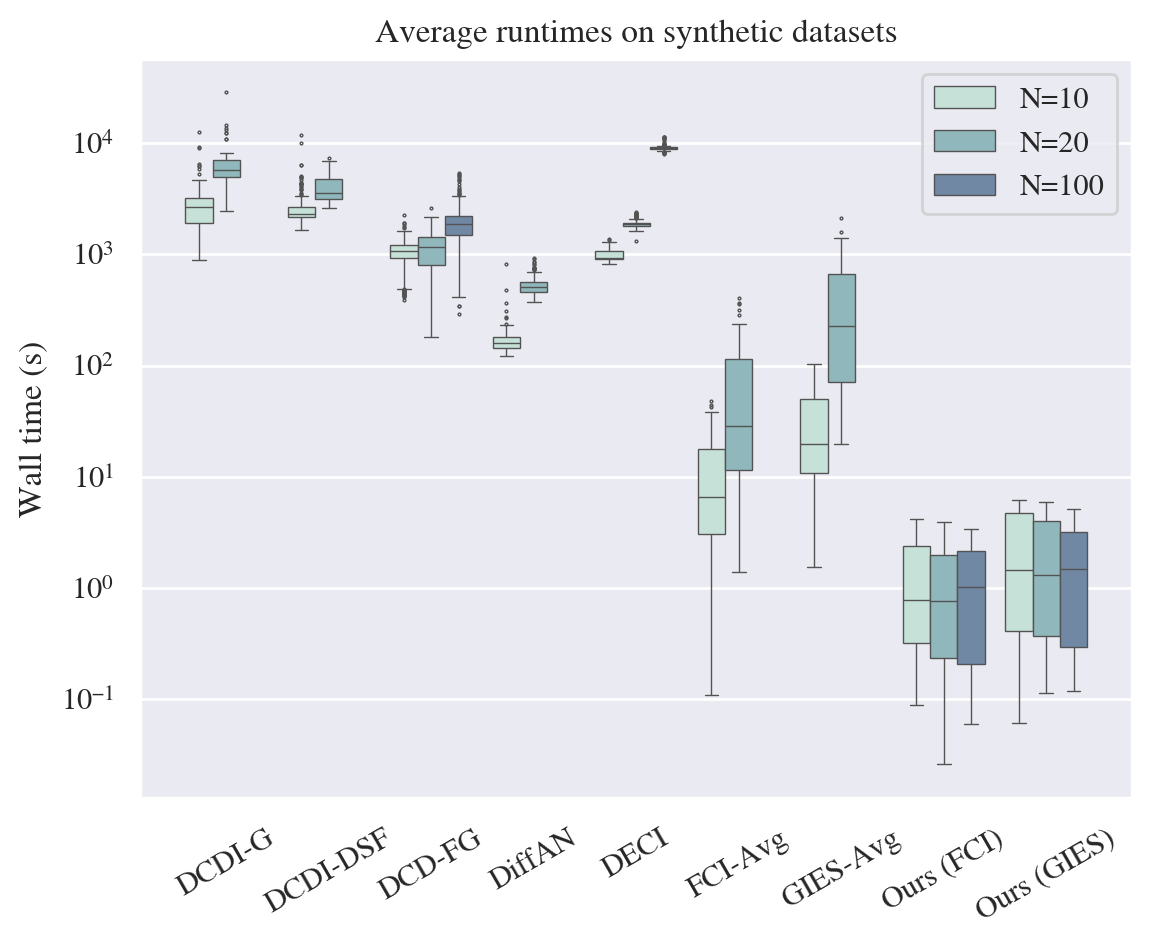

In [58]:
hue_order = ["N=10", "N=20", "N=100"]
model_order = ['DCDI-G', 'DCDI-DSF', 'DCD-FG', 'DiffAN', 'DECI',
 'FCI-Avg', 'GIES-Avg', 'Ours (FCI)', 'Ours (GIES)']
# model_order = ['Ours (FCI)', 'Ours (FCI-L)', 'Ours (GIES)', 'Ours (GIES-L)']
# palette = sns.cubehelix_palette(start=0.5, dark=0.4, rot=-.5)  # for 6 colors

# plt.figure(figsize=(6.4, 3.0))
palette = sns.cubehelix_palette(start=0.5, dark=0, rot=-.5)  # for 3 colors
ax = sns.boxplot(data=df_time, x="model", y="time", hue="setting",
                 order=model_order, hue_order=hue_order, palette=palette,
                 linewidth=0.5,
                 fliersize=1,
                 flierprops={"marker": "."},)
ax.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Wall time (s)")
plt.xlabel("")
plt.semilogy()
plt.xticks(rotation=30)
plt.title("Average runtimes on synthetic datasets")
plt.show()

# Scaling analysis

## Number of batches sampled

In [59]:
def load_numbatch_data(template):
    ours_numbatch = {}
    for num_batches in [10, 20, 30, 40, 50, 100, 200, 500]:
        fp = template.format(num_batches)
        fp = f"/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/{fp}"
        if not os.path.exists(fp):
            continue
        results = utils.read_pickle(fp)

        ours_results_dict = defaultdict(lambda: defaultdict(list))
        for k, v in results.items():
            if k.startswith("data_"):  # dcdi format
                k = k[5:]
            k = k.split(".")[0].rsplit("_", 1)[0]
            for metric in ["auc", "prc"]:
                ours_results_dict[k][metric] = v[metric]
            for true, pred in zip(v["true"], v["pred"]):
                shd, edge_mcc = compute_additional_metrics(true, pred)
                ours_results_dict[k]["shd"].append(shd)
                ours_results_dict[k]["edge_mcc"].append(edge_mcc)
            ours_results_dict[k]["time"] = v["time"]
        ours_numbatch[num_batches] = ours_results_dict
    dfs_numbatch = {}
    for metric in ["auc", "prc", "shd", "edge_mcc"]:
        all_vals = defaultdict(list)
        # ours
        for name, results in ours_numbatch.items():
            for k, v in sorted(results.items()):
                nodes, edges, mechanism = parse_key(k)
                if "SF" not in mechanism:
                    continue
                for val in v[metric]:
                    all_vals["nodes"].append(nodes)
                    all_vals["edges"].append(edges)
                    all_vals["mechanism"].append(mechanism)
                    all_vals[metric].append(val)
                    all_vals["model"].append(name)
        dfs_numbatch[metric] = pd.DataFrame.from_dict(all_vals)
    return dfs_numbatch

In [60]:
templates = {
    "Linear 500": "results/results_gies_global_{}-p100e100linear.pkl",
    "Linear 200": "results/results_gies_global_{}-200-p100e100linear.pkl",
    "Sigmoid 500": "results/results_gies_global_{}-p100e100sigmoid_add.pkl",
    "Sigmoid 200": "results/results_gies_global_{}-200-p100e100sigmoid_add.pkl",
}

In [61]:
all_numbatch = {}
for k, template in templates.items():
    all_numbatch[k] = load_numbatch_data(template)

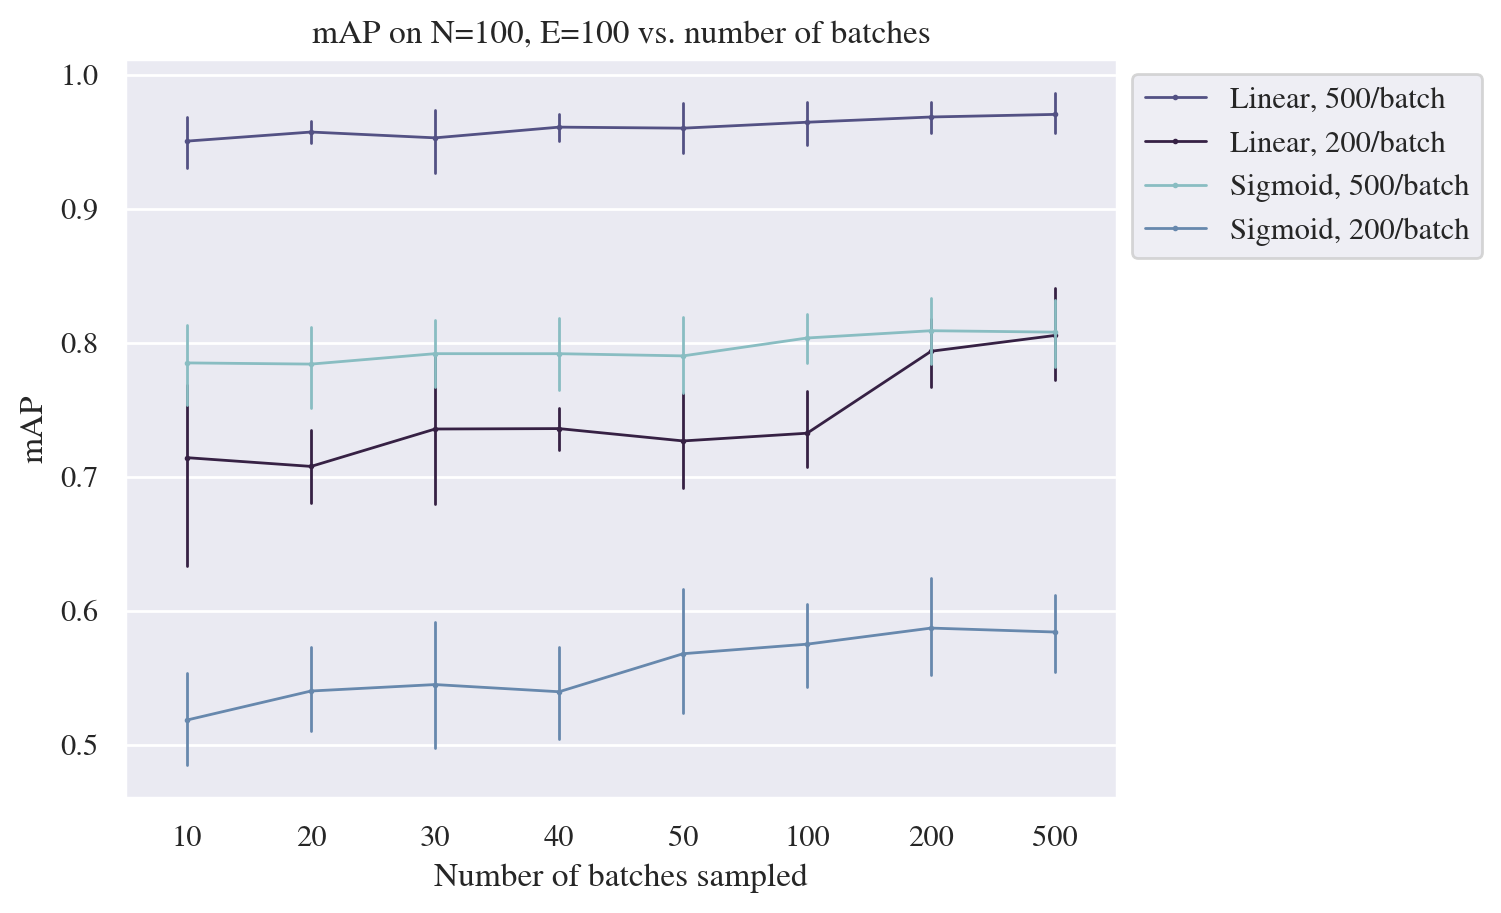

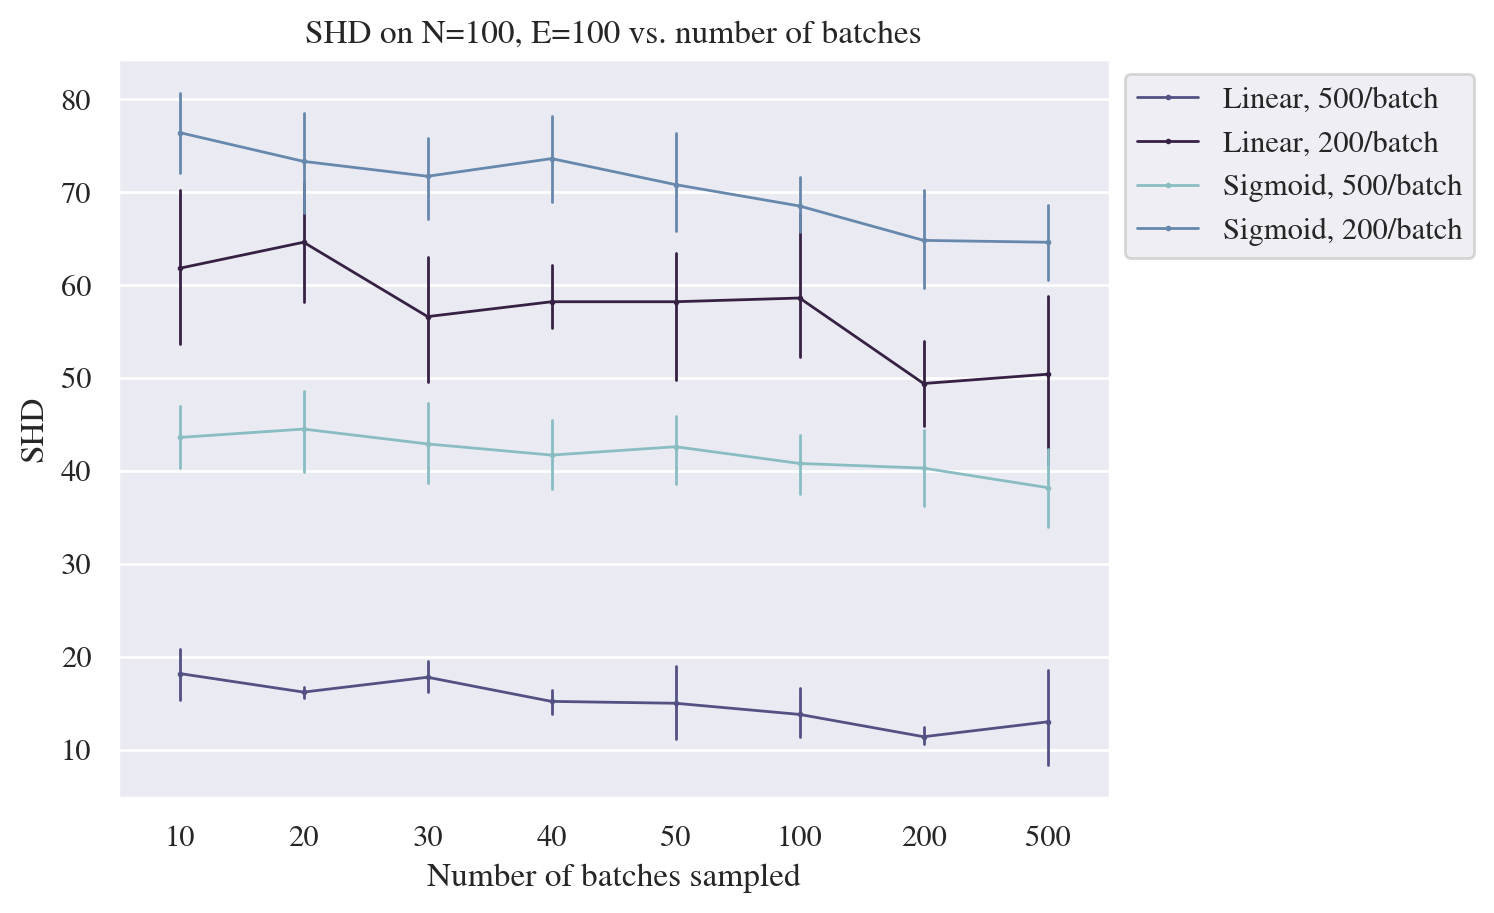

In [62]:
for metric in ["prc", "shd"]:
    kwargs = {
        "errorbar": "ci",
        "lw": 1,
        "x": "model",
        "y": metric,
        "marker": "."
    }
    ax = sns.pointplot(all_numbatch["Linear 500"][metric],
                      color=palette[3], label="Linear, 500/batch", **kwargs)
    sns.pointplot(all_numbatch["Linear 200"][metric],
                 color=palette[4], label="Linear, 200/batch", **kwargs)
    sns.pointplot(all_numbatch["Sigmoid 500"][metric],
                 color=palette[1], label="Sigmoid, 500/batch", **kwargs)
    sns.pointplot(all_numbatch["Sigmoid 200"][metric],
                 color=palette[2], label="Sigmoid, 200/batch", **kwargs)

    if metric == "prc":
        metric = "mAP"
    elif metric == "shd":
        metric = "SHD"
    ax.legend(bbox_to_anchor=(1, 1))
    plt.ylabel(metric)
    plt.xlabel("Number of batches sampled")
    plt.title(f"{metric} on N=100, E=100 vs. number of batches")
    plt.show()

## Graph size

Must load appropriate DFs into `dfs_baseline`

In [63]:
# names = ["invcov", "corr",
#          "Ours+FCI 500", "Ours+GIES 500"]

# axis_names = {
#     "invcov": "InvCov",
#     "corr": "Corr",
#     "Ours+FCI 500": "Ours+FCI",
#     "Ours+GIES 500": "Ours+GIES"
# }
# baseline_names = names[:2]

# col = "linear"
# metric = "prc"

# settings = [i*100 for i in range(1, 6)]
# e_rates = [1, 4]
# e_rates_dict = {e: {"mAP": [], "Model": [], "N": []} for e in e_rates}

# for name in names:
#     for n in settings:
#         # iterate through E options
#         for e_rate in e_rates:
#             e = e_rate * n
#             if name in baseline_names:
#                 cur_dfs = dfs_baseline
#             else:
#                 cur_dfs = dfs1k
#             df = cur_dfs[metric]
#             row = df[(df["nodes"] == n) & (df["edges"] == e) & (df["mechanism"] == col) & (df["model"] == name)]
#             val = row[metric].item()
#             e_rates_dict[e_rate]["N"].append(n)
#             e_rates_dict[e_rate]["mAP"].append(val)
#             e_rates_dict[e_rate]["Model"].append(axis_names[name])
# e_rates_dict = dict(e_rates_dict)
# for e_rate, all_vals in e_rates_dict.items():
#     e_rates_dict[e_rate] = pd.DataFrame.from_dict(all_vals)

In [64]:
# palette = sns.cubehelix_palette(start=0.3, light=0.7, rot=-.25)  # for 6 colors

# for e_rate in e_rates:
#     e_rates_dict[e_rate]
#     ax = sns.pointplot(data=e_rates_dict[e_rate], x="N", y="mAP", hue="Model",
#                        palette=palette, lw=1, marker=".")

#     ax.legend(bbox_to_anchor=(1, 1))
#     plt.ylabel("mAP")
#     plt.xlabel("Graph size N")
#     if e_rate != 1:
#         plt.title(f"mAP on Linear, E={e_rate}N")
#     else:
#         plt.title(f"mAP on Linear, E=N")
#     plt.ylim(0, 1)
#     plt.show()

## Sizes of batches sampled, 100 total

In [65]:
def load_batchsize(template):

    ours_batchsize = {}

    for batchsize in [50, 100, 125, 150, 175, 200, 250, 300, 400, 500]:
        fp = template.format(batchsize)
        fp = f"/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/{fp}"
        results = utils.read_pickle(fp)

        ours_results_dict = defaultdict(lambda: defaultdict(list))
        for k, v in results.items():
            if k.startswith("data_"):  # dcdi format
                k = k[5:]
            k = k.split(".")[0].rsplit("_", 1)[0]
            for metric in ["auc", "prc"]:
                ours_results_dict[k][metric] = v[metric]
            for true, pred in zip(v["true"], v["pred"]):
                shd, edge_mcc = compute_additional_metrics(true, pred)
                ours_results_dict[k]["shd"].append(shd)
                ours_results_dict[k]["edge_mcc"].append(edge_mcc)
            ours_results_dict[k]["time"] = v["time"]
        ours_batchsize[batchsize] = ours_results_dict

    dfs_batchsize = {}
    for metric in ["auc", "prc", "shd", "edge_mcc"]:
        all_vals = defaultdict(list)
        # ours
        for name, results in ours_batchsize.items():
            for k, v in sorted(results.items()):
                nodes, edges, mechanism = parse_key(k)
                if "SF" not in mechanism:
                    continue
                for val in v[metric]:
                    all_vals["nodes"].append(nodes)
                    all_vals["edges"].append(edges)
                    all_vals["mechanism"].append(mechanism)
                    all_vals[metric].append(val)
                    all_vals["model"].append(name)     
        dfs_batchsize[metric] = pd.DataFrame.from_dict(all_vals)

    return dfs_batchsize

In [66]:
templates = {
    "Linear 100": "results/results_gies_global_100-{}-p100e100linear.pkl",
    "Sigmoid 100": "results/results_gies_global_100-{}-p100e100sigmoid_add.pkl",
}

In [67]:
all_batchsize = {}
for k, template in templates.items():
    all_batchsize[k] = load_batchsize(template)

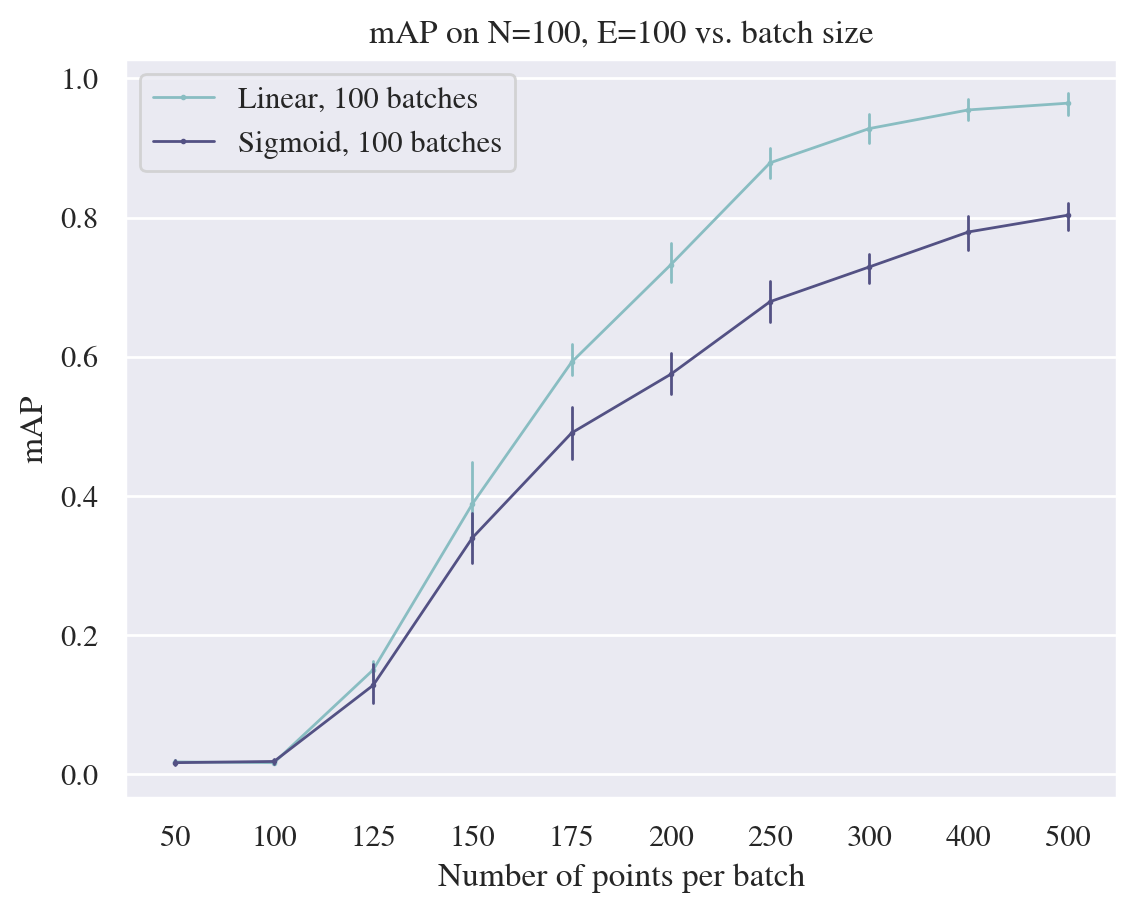

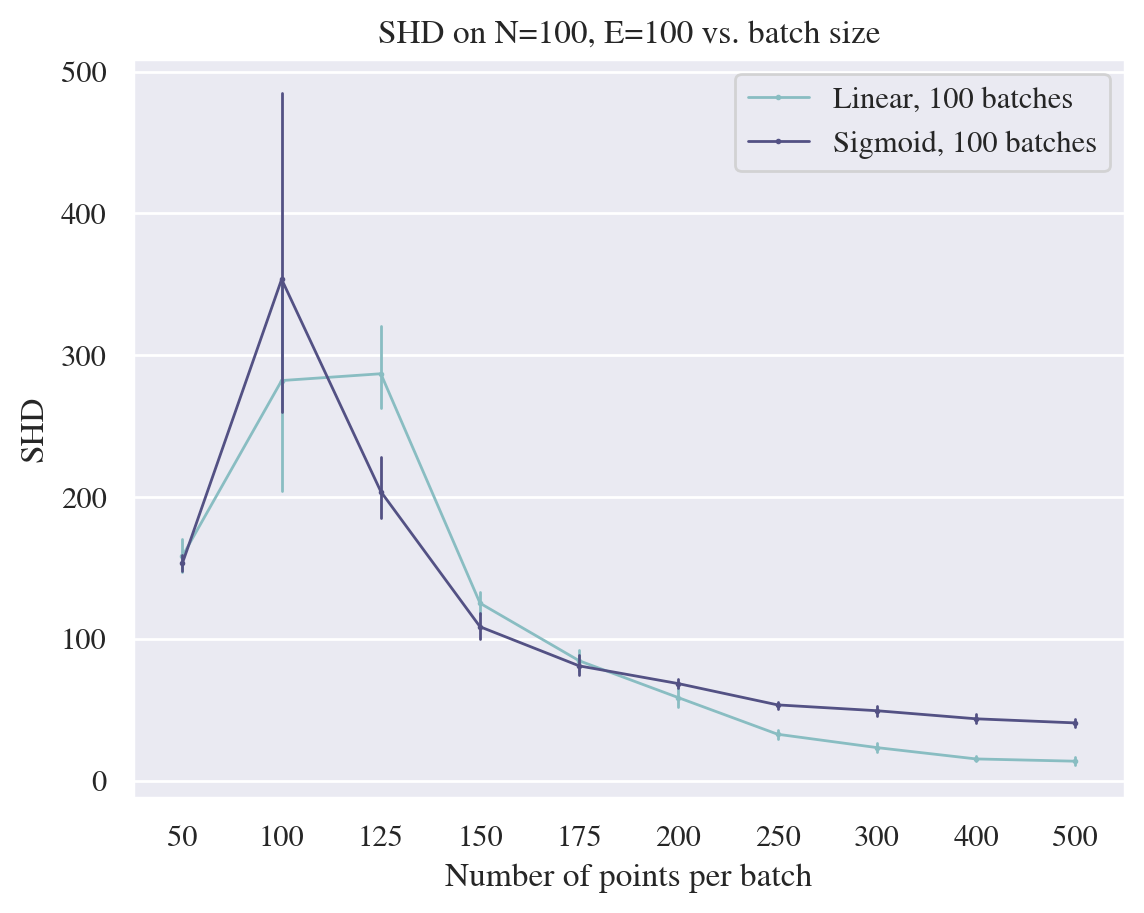

In [68]:
for metric in ["prc", "shd"]:
    kwargs = {
        "errorbar": "ci",
        "lw": 1,
        "x": "model",
        "y": metric,
        "marker": "."
    }
    ax = sns.pointplot(all_batchsize["Linear 100"][metric],
                      color=palette[1], label="Linear, 100 batches", **kwargs)
    sns.pointplot(all_batchsize["Sigmoid 100"][metric],
                  ax=ax, color=palette[3], label="Sigmoid, 100 batches", **kwargs)

#     ax.legend(bbox_to_anchor=(1, 1))
    if metric == "prc":
        metric = "mAP"
    elif metric == "shd":
        metric = "SHD"
    plt.ylabel(metric)
    plt.xlabel("Number of points per batch")
    plt.title(f"{metric} on N=100, E=100 vs. batch size")
    plt.show()

## Effective size of dataset

In [69]:
fp_data = "/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/data/intervention_8160.csv"
items = utils.read_csv(fp_data)

feature_baselines_500 = {}
for item in tqdm(items):
    if item["split"] != "test":
        continue
    fp = item["fp_data"]
    if "e100" not in fp and "e400" not in fp:
        continue
    if "linear" not in fp and "sigmoid_add" not in fp:
        continue
    if "SF" in fp:
        continue
    data = np.load(item["fp_data"])[:500]
    label = np.load(item["fp_graph"])
    # exclude diagonal from evaluation
    diag_mask = ~np.eye(data.shape[1], dtype=bool)
    label = label[diag_mask]
    # inverse covariance
#     invcovs = np.linalg.pinv(np.cov(data.T, bias=True), rcond=1e-10)[diag_mask]
    lw = LedoitWolf()
    lw.fit(data)
    invcovs = lw.get_precision()
    invcovs = np.abs(invcovs)[diag_mask]
    feature_baselines_500[item["fp_data"]] = {
        "label": label,
        "invcov": invcovs,
    }

all_naive_baselines_500 = {}
model = "invcov"
baseline_dicts = defaultdict(lambda: defaultdict(list))
for fp, item in feature_baselines_500.items():
    if model not in item:
        continue
    if "sachs" in fp:
        key = "sachs"
        n, e = 11, 17
    else:
        key = fp.split("/")[-2][5:].rsplit("_", 1)[0]  # remove data_ prefix
        n, e, _ = parse_key(key)
    true = item["label"]
    pred = item[model]
    baseline_dicts[key]["auc"].append(roc_auc_score(true, pred))
    baseline_dicts[key]["prc"].append(average_precision_score(true, pred))
    pos_rate = e / n**2
    threshold = np.quantile(pred, 1 - pos_rate)
    shd, edge_mcc = compute_additional_metrics(true, pred, threshold)
    baseline_dicts[key]["shd"].append(shd)
    baseline_dicts[key]["edge_mcc"].append(edge_mcc)
for k,v in baseline_dicts.items():
    for metric, vals in v.items():
        baseline_dicts[k][metric] = np.mean(vals), np.std(vals)

all_naive_baselines_500[model] = baseline_dicts
    
dfs_baseline_500 = {}
for metric in ["auc", "prc", "shd", "edge_mcc"]:
    # ours_baselines_500
    all_vals = defaultdict(list)
    for name, results in all_naive_baselines_500.items():
        for k, v in sorted(results.items()):
            nodes, edges, mechanism = parse_key(k)
            all_vals["nodes"].append(nodes)
            all_vals["edges"].append(edges)
            all_vals["mechanism"].append(mechanism)
            all_vals[metric].append(v[metric][0])
            all_vals["std"].append(v[metric][1])
            all_vals["model"].append(name)        

    dfs_baseline_500[metric] = pd.DataFrame.from_dict(all_vals)

8161 lines	/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/data/intervention_8160.csv


100%|███████████████████████████████████████| 8161/8161 [00:00<00:00, 9770.25it/s]


In [70]:
dfs_baseline_500["shd"]

,nodes,edges,mechanism,shd,std,model
0,100,100,linear,112.0,7.483,invcov
1,100,100,sigmoid_add,103.4,14.009,invcov
2,100,400,linear,483.2,16.314,invcov
3,100,400,sigmoid_add,476.3,18.429,invcov


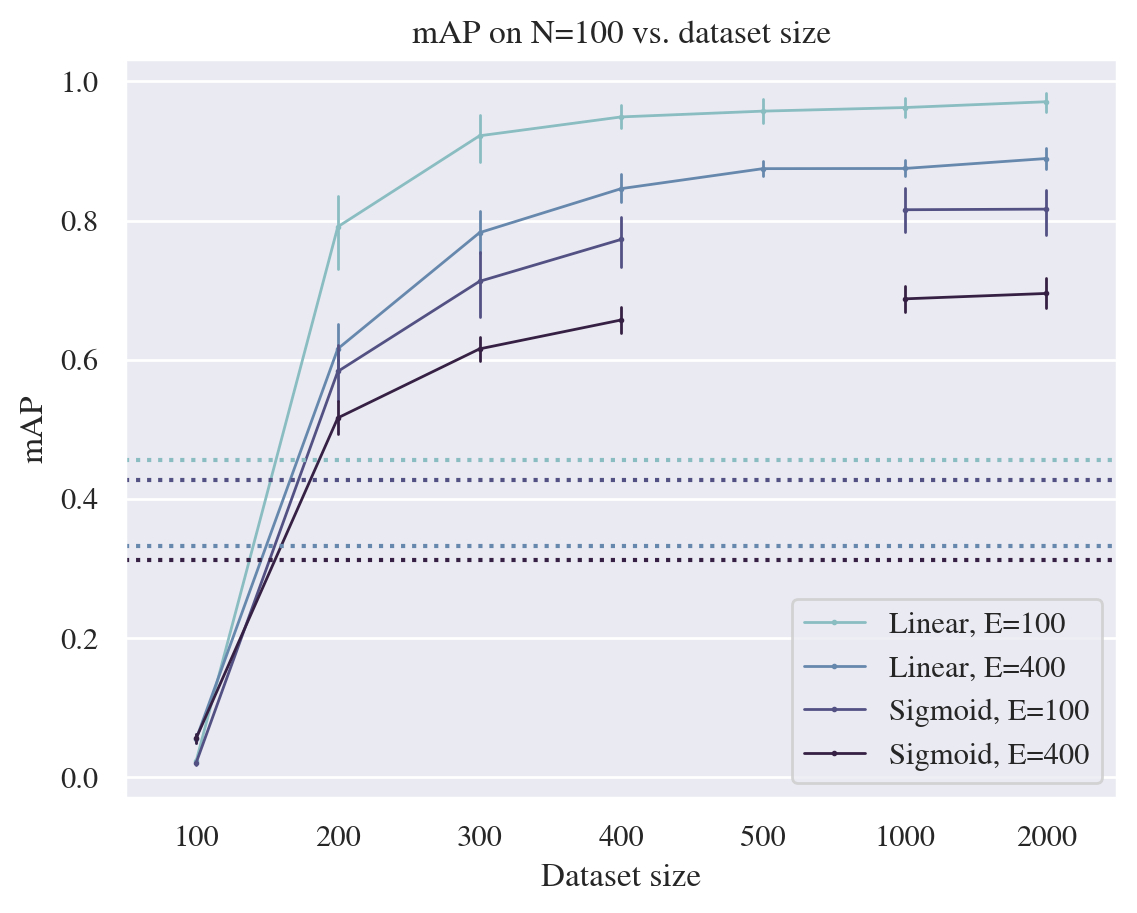

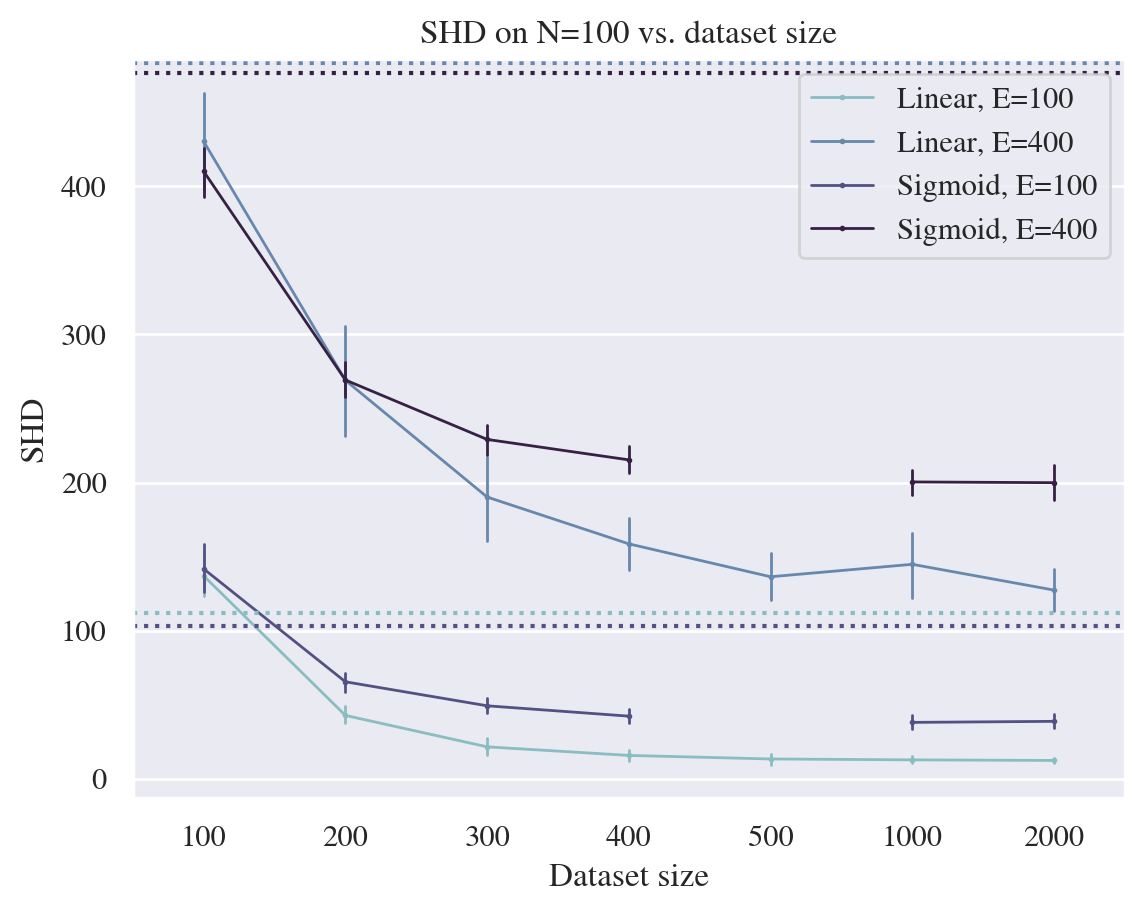

In [71]:
def load_datasize(template):

    ours_datasize = {}

    for datasize in [100, 200, 300, 400, 500, 1000, 2000]:
        fp = template.format(datasize)
        fp = f"/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/{fp}"
        if not os.path.exists(fp):
            continue
        results = utils.read_pickle(fp)

        ours_results_dict = defaultdict(lambda: defaultdict(list))
        for k, v in results.items():
            if k.startswith("data_"):  # dcdi format
                k = k[5:]
            k = k.split(".")[0].rsplit("_", 1)[0]
            for metric in ["auc", "prc"]:
                ours_results_dict[k][metric] = v[metric]
            for true, pred in zip(v["true"], v["pred"]):
                shd, edge_mcc = compute_additional_metrics(true, pred)
                ours_results_dict[k]["shd"].append(shd)
                ours_results_dict[k]["edge_mcc"].append(edge_mcc)
            ours_results_dict[k]["time"] = v["time"]
        ours_datasize[datasize] = ours_results_dict

    dfs_datasize = {}
    for metric in ["auc", "prc", "shd", "edge_mcc"]:
        all_vals = defaultdict(list)
        # ours
        for name, results in ours_datasize.items():
            for k, v in sorted(results.items()):
                nodes, edges, mechanism = parse_key(k)
                if "SF" not in mechanism:
                    continue
                for val in v[metric]:
                    all_vals["nodes"].append(nodes)
                    all_vals["edges"].append(edges)
                    all_vals["mechanism"].append(mechanism)
                    all_vals[metric].append(val)
                    all_vals["model"].append(name)     
        dfs_datasize[metric] = pd.DataFrame.from_dict(all_vals)

    return dfs_datasize

templates = {
    "Linear 100": "results/results_fci_n{}_linear.pkl",
    "Sigmoid 100": "results/results_fci_n{}.pkl",
}

all_datasize = {}
for k, template in templates.items():
    all_datasize[k] = load_datasize(template)

# computed from above
invcov_baselines = {
    "prc": [
        0.456, 0.333, 0.427, 0.312
    ],
    "shd": [
        112.0, 483.2, 103.4, 476.3
    ]
}

for metric in ["prc", "shd"]:
    kwargs = {
        "errorbar": "ci",
        "lw": 1,
        "x": "model",
        "y": metric,
        "marker": "."
    }
    df_linear = all_datasize["Linear 100"][metric]
    df_sigmoid = all_datasize["Sigmoid 100"][metric]
    ax = sns.pointplot(df_linear[df_linear["edges"] == 100],
                      color=palette[1], label="Linear, E=100", **kwargs)
    sns.pointplot(df_linear[df_linear["edges"] == 400],
                  ax=ax, color=palette[2], label="Linear, E=400", **kwargs)
    sns.pointplot(df_sigmoid[df_sigmoid["edges"] == 100],
                  ax=ax, color=palette[3], label="Sigmoid, E=100", **kwargs)
    sns.pointplot(df_sigmoid[df_sigmoid["edges"] == 400],
                  ax=ax, color=palette[4], label="Sigmoid, E=400", **kwargs)
    
    # invcov reference
    for i, val in enumerate(invcov_baselines[metric]):
        ax.axhline(y=val, color=palette[i+1], linestyle=":")

#     ax.legend(bbox_to_anchor=(1, 1)
    if metric == "prc":
        metric = "mAP"
    elif metric == "shd":
        metric = "SHD"
    plt.ylabel(metric)
    plt.xlabel("Dataset size")
    plt.title(f"{metric} on N=100 vs. dataset size")
    plt.show()

## Number of variables per batch

In [72]:
def load_numvars(template):

    ours_numvars = {}

    for numvars in range(3,11):
        fp = template.format(numvars)
        fp = f"/data/rsg/chemistry/rmwu/src/sandbox/sc-rl/{fp}"
        results = utils.read_pickle(fp)

        ours_results_dict = defaultdict(lambda: defaultdict(list))
        for k, v in results.items():
            if k.startswith("data_"):  # dcdi format
                k = k[5:]
            k = k.split(".")[0].rsplit("_", 1)[0]
            for metric in ["auc", "prc"]:
                ours_results_dict[k][metric] = v[metric]
            for true, pred in zip(v["true"], v["pred"]):
                shd, edge_mcc = compute_additional_metrics(true, pred)
                ours_results_dict[k]["shd"].append(shd)
                ours_results_dict[k]["edge_mcc"].append(edge_mcc)
            ours_results_dict[k]["time"] = [t.item() for t in v["time"]]
        ours_numvars[numvars] = ours_results_dict

    dfs_numvars = {}
    for metric in ["auc", "prc", "shd", "edge_mcc", "time"]:
        all_vals = defaultdict(list)
        # ours
        for name, results in ours_numvars.items():
            for k, v in sorted(results.items()):
                nodes, edges, mechanism = parse_key(k)
                if "SF" not in mechanism:
                    continue
                for val in v[metric]:
                    all_vals["nodes"].append(nodes)
                    all_vals["edges"].append(edges)
                    all_vals["mechanism"].append(mechanism)
                    all_vals[metric].append(val)
                    all_vals["model"].append(name) 
        dfs_numvars[metric] = pd.DataFrame.from_dict(all_vals)

    return dfs_numvars

In [73]:
templates = {
    "Sigmoid": "results/results_gies_global_p100e100sigmoid_add-{}.pkl",
    "Polynomial": "results/results_gies_global_p100e100poly-{}.pkl",
}

In [74]:
all_numvars = {}
for k, template in templates.items():
    all_numvars[k] = load_numvars(template)

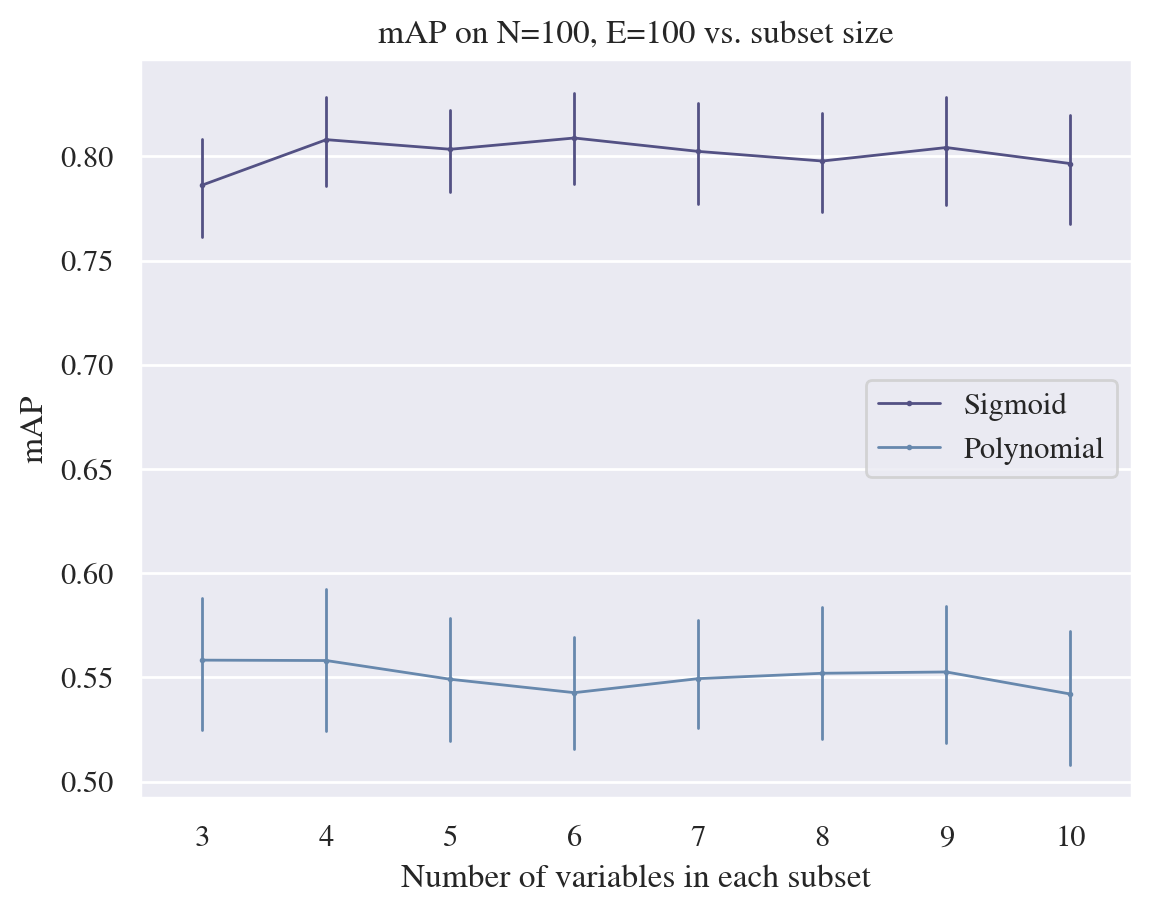

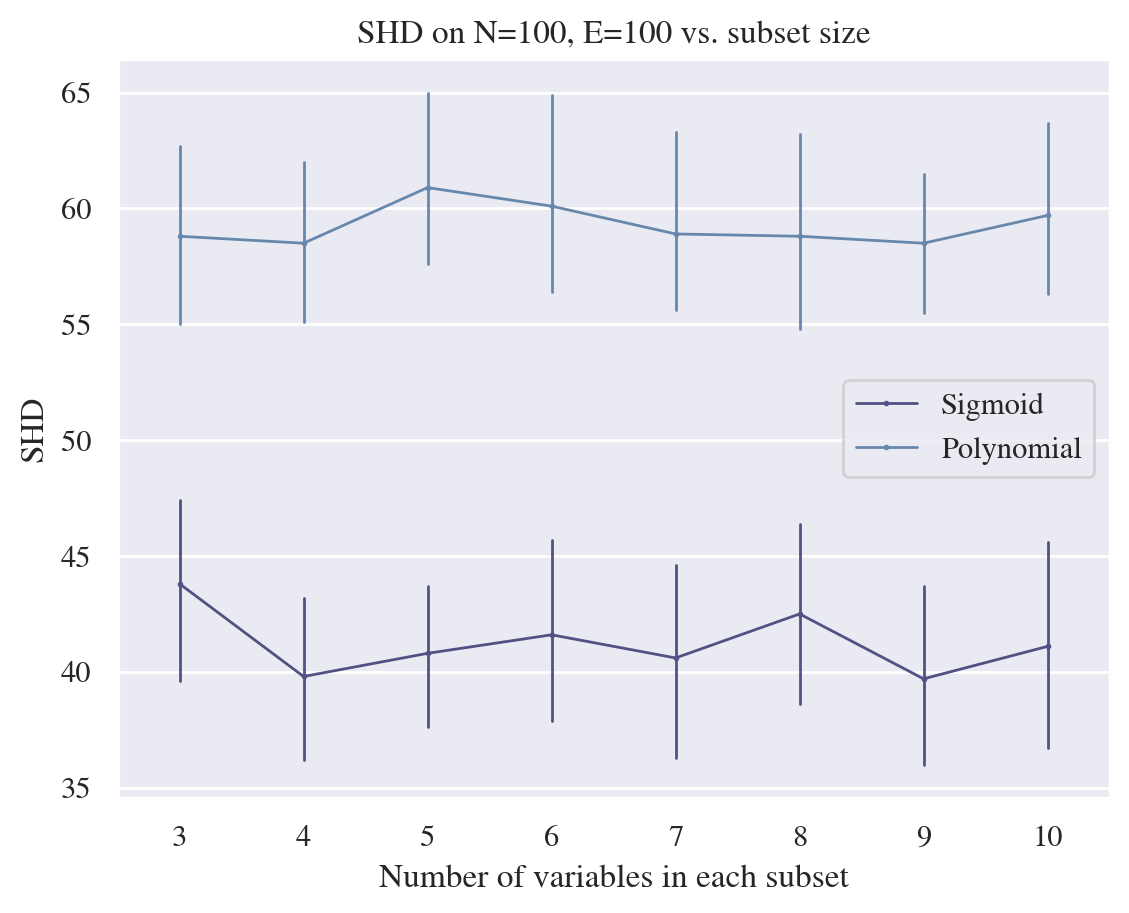

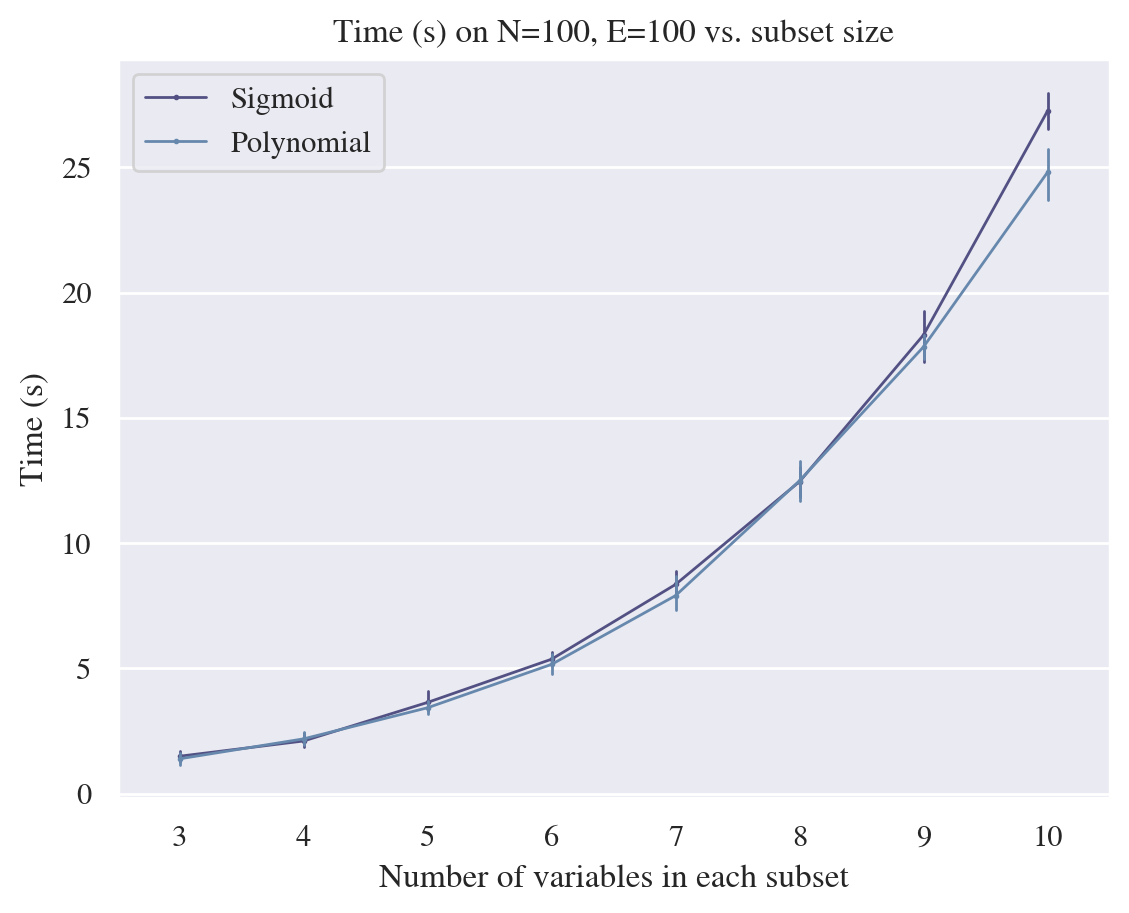

In [75]:
for metric in ["prc", "shd", "time"]:
    kwargs = {
        "errorbar": "ci",
        "lw": 1,
        "x": "model",
        "y": metric,
        "marker": "."
    }
    ax = sns.pointplot(all_numvars["Sigmoid"][metric],
                      color=palette[3], label="Sigmoid", **kwargs)
    sns.pointplot(all_numvars["Polynomial"][metric],
                  ax=ax, color=palette[2], label="Polynomial", **kwargs)

#     ax.legend(bbox_to_anchor=(1, 1))
    if metric == "prc":
        metric = "mAP"
    elif metric == "shd":
        metric = "SHD"
    elif metric == "time":
        metric = "Time (s)"
    plt.ylabel(metric)
    plt.xlabel("Number of variables in each subset")
    plt.title(f"{metric} on N=100, E=100 vs. subset size")
    plt.show()